# Classification workbook + Results


The notebook contains code for developing the classification models + predicting on the unlabelled data. Next, the results are conducted.

Libraries:

In [ ]:
pip install spacy


In [ ]:
!python -m spacy download da_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 17.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('da_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import pandas as pd
import spacy
import re
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix, hstack


In [ ]:
# danish stopwords model
nlp = spacy.load("da_core_news_sm")

stopwords = nlp.Defaults.stop_words
print(stopwords)



{'vi', 'via', 'bliver', 'hvordan', 'blive', 'flere', 'fleste', 'imellem', 'have', 'hvilke', 'hvor', 'lidt', 'undtagen', 'derpå', 'egen', 'dig', 'igen', 'disse', 'mange', 'hvorimod', 'hende', 'mindst', 'da', 'ved', 'blandt', 'lad', 'meget', 'derved', 'fra', 'ham', 'hen', 'andet', 'lave', 'med', 'op', 'denne', 'en', 'ens', 'lav', 'må', 'der', 'temmelig', 'før', 'hel', 'til', 'har', 'dermed', 'skal', 'hvorefter', 'eller', 'tidligere', 'derfra', 'mig', 'syntes', 'os', 'forrige', 'et', 'derfor', 'dette', 'ses', 'først', 'skulle', 'hvori', 'andre', 'hendes', 'ind', 'gjort', 'indtil', 'havde', 'dem', 'god', 'blev', 'henover', 'hvilken', 'sammen', 'vore', 'hver', 'deri', 'alle', 'hvorfor', 'sige', 'samme', 'min', 'hvilkes', 'din', 'for', 'fordi', 'lille', 'hans', 'var', 'alt', 'dine', 'noget', 'burde', 'hermed', 'mindre', 'mine', 'næsten', 'begge', 'omkring', 'ene', 'herpå', 'på', 'hvem', 'ny', 'dog', 'jeg', 'nyt', 'imod', 'nogle', 'ud', 'flest', 'ingen', 'heri', 'kunne', 'mere', 'øvrigt', 'ma

Importing files:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
df_final = pd.read_csv('/content/gdrive/My Drive/Thesis/Data/final_final_final_sample.csv')

In [ ]:
df_final

url  \
0     https://nyheder.tv2.dk/krimi/2024-08-08-rigspo...   
1     https://nyheder.tv2.dk/tech/2019-01-20-der-kan...   
2     https://echo.tv2.dk/samfund/2020-01-07-24-aari...   
3     https://nyheder.tv2.dk/2015-02-02-forbrugerraa...   
4     https://nyheder.tv2.dk/business/2021-06-01-ans...   
...                                                 ...   
2676  https://jv.dk/bolig-og-livsstil/adam-laeser-ku...   
2677  https://jv.dk/udland/eu-naar-frem-til-aftale-o...   
2678  https://jv.dk/danmark/minister-dropper-krav-om...   
2679  https://jv.dk/danmark/venstre-vil-have-oekonom...   
2680  https://jv.dk/esbjerg/sikkerhedsvagter-fjernet...   

                     search_term        date  \
0             facial recognition  2024-08-08   
1             facial recognition  2019-01-20   
2             facial recognition  2020-01-07   
3             facial recognition  2015-02-02   
4             facial recognition  2021-06-01   
...                          ...         ...   
2676          ansigtsgenkendelse  2024-01-09   
2677          ansigtsgenkendelse  2023-12-08   
2678  overvågningssamfund ansigt  2024-06-05   
2679     tryghedsskabende kamera  2024-08-15   
2680     tryghedsskabende kamera  2024-05-11   

                                         merged_content             source  \
0     rigspolitichef forsøger at berolige befolkning...                TV2   
1     fc københavn vil benytte sig af ansigtsgenkend...                TV2   
2     politiet tager hul på første projekt med ansig...                TV2   
3     lufthavn i singapore erstatter pas med ansigts...                TV2   
4     ansigtsgenkendelse blev stridspunktet i eu dan...                TV2   
...                                                 ...                ...   
2676  adam læser kunstig intelligens vil gøre livet ...  Jydske Vestkysten   
2677  eu når frem til regler for kunstig intelligens...  Jydske Vestkysten   
2678  minister dropper krav om videoovervågning af f...  Jydske Vestkysten   
2679  venstre vil have økonomisk kriminelle til at b...  Jydske Vestkysten   
2680  sikkerhedsvagter fjernet fra farlig arbejdspla...  Jydske Vestkysten   

      categorisation political_orientation  
0     Public service               Neutral  
1     Public service               Neutral  
2     Public service               Neutral  
3     Public service               Neutral  
4     Public service               Neutral  
...              ...                   ...  
2676  Regional paper          Center-right  
2677  Regional paper          Center-right  
2678  Regional paper          Center-right  
2679  Regional paper          Center-right  
2680  Regional paper          Center-right  

[2681 rows x 7 columns]

In [ ]:
df_annotated = pd.read_excel('/content/gdrive/My Drive/Thesis/Samples/labeled_sample.xlsx')


In [ ]:

frame_columns = [
    'Surveillance and privacy concerns',
    'Orwellian Surveillance',
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Algorithmic bias or discrimination'
]

# counting the number of 1's in each frame column
frame_counts = df_annotated[frame_columns].sum()

print("Number of 1's in each frame column:")
print(frame_counts)


Number of 1's in each frame column:
Surveillance and privacy concerns                  106
Orwellian Surveillance                             107
FRT as a tool for Security and crime prevention    105
FRT: the new standard                              108
Algorithmic bias or discrimination                 104
dtype: int64


# Preprocessing

First, a bit of cleaning the data before we can run the models.

Stopwords were lightly removed using SpaCy’s Danish NLP stopwords model (SpaCy, n.d.), however, the influence of stopword removal on performance was tested, as TF-IDF often performs better without a complete removal of stopwords; when removing very frequent words, which otherwise would have received a very low weight by TD-IDF’s vectorization, words which initially had a higher TF-IDF score now becomes the more frequent words, receiving lower weights, ultimately skewing the distribution of weights and affecting results (Lingadeu, 2024). As such, when a more extensive stop words library was tested, performance decreased. However, removal of very common stop words to reduce noise increased performance.

In [ ]:

nlp = spacy.load("da_core_news_sm")

# creating the frame-specific feature
keywords = {
    'Surveillance and privacy concerns': [r'persondatakrænkelse', r'krænkelse', r'privatliv', r'personfølsomme', r'frihedsrettigheder', r'frihed', r'indskrænk', r'indgreb', r'privatliv', r'anonymitet', r'udspil', r'retssikkerhed', r'misbrug', r'datamisbrug', r'datasikkerhed', r'borgerrettigheder'],
    'Orwellian Surveillance': [r'brother', r'fiction', r'totalitær', r'panopt', r'autoritær', r'kreditsystem', r'dystop', r'pointsystem', r'panoptikon', r'diktatur', r'overvågningsstat', r'autoritarisme', r'kontrolsamfund', r'frihedsberøvelse', r'overvågningskamera', r'censur', r'kina', r'1984', r'orwell', r'overvågningskultur', r'samfundskontrol', r'singapore', r'hongkong'],
    'FRT as a tool for Security and crime prevention': [r'menneskeliv', r'redskab', r'værktøj', r'beskyt', r'band', r'vold', r'prævent', r'forebygg', r'kriminalitetsbekæmp', r'efterforsk', r'sverige', r'svensk', r'børnesoldat', r'gerningsmænd', r'skyderi', r'sikkerhed', r'kriminalitetsforebygg', r'terrorbekæmp', r'hooligan', r'kriminalitetsovervåg', r'politioperation', r'fodboldbøl', r'voldsmænd'],
    'FRT: the new standard': [r'iphone', r'funktionalitet', r'facebook', r'galaxy', r'face id', r'apple', r'features', r'smartphones?', r'cook', r'tesla', r'brugervenlighed', r'unlock', r'brugeroplevelse'],
    'Algorithmic bias and discrimination': [r'bias', r'diskrimin', r'race', r'racistisk' r'profillering', r'ghetto', r'indvandrer', r'immigran', r'hudfarve', r'racemæssig', r'margin', r'undertrykk', r'mørkhud', r'minorit', r'lejre', r'raceprofilering']
}

# Light cleaning so keywords can be matched
def initial_clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-ZæøåÆØÅ\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#  initial cleaning
df_annotated['initial_cleaned_content'] = df_annotated['merged_content'].apply(initial_clean_text)

# function to extract features based on regex keywords
def extract_keyword_features_regex(df, keywords):
    for frame, patterns in keywords.items():
        regex = '|'.join(patterns)
        df[frame + '_keywords'] = df['initial_cleaned_content'].apply(lambda x: bool(re.search(regex, x, flags=re.IGNORECASE)))
    return df

#
df_annotated = extract_keyword_features_regex(df_annotated, keywords)

# more cleaning
def full_clean_text(text):
    doc = nlp(text)
    cleaned = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    return cleaned

df_annotated['cleaned_content'] = df_annotated['merged_content'].apply(full_clean_text)

df_annotated


url  \
0    https://ekstrabladet.dk/sport/fodbold/dansk_fo...   
1    https://ekstrabladet.dk/krimi/politiets-overva...   
2    https://www.dr.dk/nyheder/seneste/eu-parlament...   
3    https://ing.dk/artikel/nye-teknologier-baeres-...   
4    https://www.dr.dk/nyheder/seneste/efter-utilfr...   
..                                                 ...   
395  https://www.berlingske.dk/politik/fra-folketin...   
396  https://nyheder.tv2.dk/politik/2015-10-14-fler...   
397  https://nyheder.tv2.dk/udland/2023-02-02-erfan...   
398  https://www.bt.dk/krimi/politiet-tager-hul-paa...   
399  https://www.berlingske.dk/opinion/chokdoktrine...   

                     search_term                 date  \
0             ansigtsgenkendelse           2022-10-09   
1        masseovervågning ansigt           2017-12-26   
2             ansigtsgenkendelse           2023-06-14   
3             ansigtsgenkendelse           2016-08-05   
4                  ansigtskamera           2021-07-12   
..                           ...                  ...   
395  sikkerhedspakke overvågning  2019-12-09 00:00:00   
396   overvågningssamfund ansigt  2015-10-14 00:00:00   
397   overvågningssamfund ansigt  2023-02-02 00:00:00   
398           ansigtsgenkendelse           2024-08-31   
399  sikkerhedspakke overvågning           2020-11-17   

                                        merged_content                 source  \
0    brøndby vil skærpe tilskuerkontrol stigende pr...           Ekstrabladet   
1    politiets overvågningsudstyr smadret af ukendt...           Ekstrabladet   
2    de folkevalgte i eu parlamentet har i dag vedt...                     DR   
3    nye teknologier bæres ind til ol ol er ofte st...  Teknologiens mediehus   
4    salling group der står bag butikker som netto ...                     DR   
..                                                 ...                    ...   
395  fra folketingets talerstol talte justitsminist...             Berlingske   
396  flertal kræver overvågningskameraer registrere...                    TV2   
397  droner skal overvåge svensk by efter angreb me...                    TV2   
398  rigspolitiet har hentet tilbud på software til...                     BT   
399  chokdoktrinen er tilbage vi skal jages en skræ...             Berlingske   

              categorisation              political_orientation  \
0                    Tabloid                       Left-leaning   
1                    Tabloid                       Left-leaning   
2             Public service                            Neutral   
3    Specialized publication  Technology-focused, non-political   
4             Public service                            Neutral   
..                       ...                                ...   
395      National broadsheet                      Right-leaning   
396           Public service                            Neutral   
397           Public service                            Neutral   
398                  Tabloid                      Right-leaning   
399      National broadsheet                      Right-leaning   

     Surveillance and privacy concerns  Orwellian Surveillance  \
0                                    0                       0   
1                                    0                       0   
2                                    0                       0   
3                                    0                       0   
4                                    0                       0   
..                                 ...                     ...   
395                                  1                       0   
396                                  0                       0   
397                                  0                       0   
398                                  0                       0   
399                                  0                       0   

     FRT as a tool for Security and crime prevention  FRT: the new standard  \
0                  

In [ ]:
# Doing the same for the unlabelled dataset of cleaning and creating the added featuee

df_unlabeled['initial_cleaned_content'] = df_unlabeled['merged_content'].apply(initial_clean_text)

df_unlabeled = extract_keyword_features_regex(df_unlabeled, keywords)

df_unlabeled['cleaned_content'] = df_unlabeled['merged_content'].apply(full_clean_text)

df_unlabeled


<ipython-input-105-33b618dd1041>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['initial_cleaned_content'] = df_unlabeled['merged_content'].apply(initial_clean_text)
<ipython-input-104-414cd4fa4e14>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[frame + '_keywords'] = df['initial_cleaned_content'].apply(lambda x: bool(re.search(regex, x, flags=re.IGNORECASE)))
<ipython-input-104-414cd4fa4e14>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

url  \
0     https://nyheder.tv2.dk/krimi/2024-08-08-rigspo...   
1     https://nyheder.tv2.dk/tech/2019-01-20-der-kan...   
2     https://echo.tv2.dk/samfund/2020-01-07-24-aari...   
3     https://nyheder.tv2.dk/2015-02-02-forbrugerraa...   
4     https://nyheder.tv2.dk/business/2021-06-01-ans...   
...                                                 ...   
2676  https://jv.dk/bolig-og-livsstil/adam-laeser-ku...   
2677  https://jv.dk/udland/eu-naar-frem-til-aftale-o...   
2678  https://jv.dk/danmark/minister-dropper-krav-om...   
2679  https://jv.dk/danmark/venstre-vil-have-oekonom...   
2680  https://jv.dk/esbjerg/sikkerhedsvagter-fjernet...   

                     search_term        date  \
0             facial recognition  2024-08-08   
1             facial recognition  2019-01-20   
2             facial recognition  2020-01-07   
3             facial recognition  2015-02-02   
4             facial recognition  2021-06-01   
...                          ...         ...   
2676          ansigtsgenkendelse  2024-01-09   
2677          ansigtsgenkendelse  2023-12-08   
2678  overvågningssamfund ansigt  2024-06-05   
2679     tryghedsskabende kamera  2024-08-15   
2680     tryghedsskabende kamera  2024-05-11   

                                         merged_content             source  \
0     rigspolitichef forsøger at berolige befolkning...                TV2   
1     fc københavn vil benytte sig af ansigtsgenkend...                TV2   
2     politiet tager hul på første projekt med ansig...                TV2   
3     lufthavn i singapore erstatter pas med ansigts...                TV2   
4     ansigtsgenkendelse blev stridspunktet i eu dan...                TV2   
...                                                 ...                ...   
2676  adam læser kunstig intelligens vil gøre livet ...  Jydske Vestkysten   
2677  eu når frem til regler for kunstig intelligens...  Jydske Vestkysten   
2678  minister dropper krav om videoovervågning af f...  Jydske Vestkysten   
2679  venstre vil have økonomisk kriminelle til at b...  Jydske Vestkysten   
2680  sikkerhedsvagter fjernet fra farlig arbejdspla...  Jydske Vestkysten   

      categorisation political_orientation  \
0     Public service               Neutral   
1     Public service               Neutral   
2     Public service               Neutral   
3     Public service               Neutral   
4     Public service               Neutral   
...              ...                   ...   
2676  Regional paper          Center-right   
2677  Regional paper          Center-right   
2678  Regional paper          Center-right   
2679  Regional paper          Center-right   
2680  Regional paper          Center-right   

                                initial_cleaned_content  \
0     rigspolitichef forsøger at berolige befolkning...   
1     fc københavn vil benytte sig af ansigtsgenkend...   
2     politiet tager hul på første projekt med ansig...   
3     lufthavn i singapore erstatter pas med ansigts...   
4     ansigtsgenkendelse blev stridspunktet i eu dan...   
...                                                 ...   
2676  adam læser kunstig intelligens vil gøre livet ...   
2677  eu når frem til regler for kunstig intelligens...   
2678  minister dropper krav om videoovervågning af f...   
2679  venstre vil have økonomisk kriminelle til at b...   
2680  sikkerhedsvagter fjernet fra farlig arbejdspla...   

      Surveillance and privacy concerns_keywords  \
0                                          False   
1                                          False   
2                                           True   
3                                          False   
4                                          False   
...                                          ...   
2676                                        True   
2677                                       False   
2678                                       False   
2679                                        Tru

In [ ]:
# I accidently changed the name of the frame in the dataset when i labelled it manually.
# Here I change it back:

df_annotated = df_annotated.rename(columns={'Algorithmic bias or discrimination': 'Algorithmic bias and discrimination'})

# Classification for each frame:

Doing experimentation with the frames and building their models, we see how the models perform differently when including additional parameters or not and using different sampling strategies. From a more qualitative viewpoint, and given our understanding of the phenomenon after having done the qualitative analysis, this also makes sense: the frames have different semantic structures and sets of linguistic patterns, as we found. Thus, these differences mean that the models need to capture different kinds of patterns and complexities --> why they might also need different settings. as such, below we will try to optimize the performance for each model for each frame, making it able to capture the frames in the article so we can scale it up to the entire dataset.



Three models are built for each frame:

1. TFIDF vectorization +n-grams
2. TFIDF vectorization + frame-specific keyword + SMOTE
3. TFIDF vectorization + n-grams + SMOTE


To follow a general and streamlined approach throughout the development of the models, a pipeline with four components were utilized for the training set before classification:
Vectorization: Data was transformed into TF-IDF format for all models, however, depending on the model setup, two different approaches were employed:  For models without the the added frame-specific feature, vectorization was combined with n-grams (1-3) and max_feature limited to 5000, to avoid including features with less informative words, introducing noise and reduce the risk of overfitting; For models which included the extra variable as feature, the TF-IDF vectors were combined with the sparse matrix of the frame-specific feature without considering n-grams.


*SMOTE:* Due to the high class imbalance in the labeled dataset, on which the models were developed, different resampling techniques were tested to accommodate the issue. Both SMOTE and random under-sampling showed high performance, however, given the limited size of the dataset, undersampling was not employed further, as not to remove data which we already have not a lot of. Instead, SMOTE was employed for two of the three models developed for each frame, creating synthetic minority class examples, thus oversampling the minority class in the training set.

*Singular value decomposition (SVD):* dimensionality reduction methods like SVD are often employed in text classification tasks, as this enables the models in using a smaller number of dimensions, which are still able to capture the variation in the data, but which provide fewer possibilities for the model to overfit by exploring spurious patterns (Hovy, 2020). Given the relatively limited datasize, the number of components was determined at a relatively low threshold of 100 to simplify the models’ input space, however, still making sure that the most important information from the 5000 features is included.

*Logistic regression model:* denoting the choice of model. class_weight set to balanced as to increase the weight of minority class examples, mitigating the risk of the model to overfit to the majority class, but pay equal attention to less-presented examples. The solver='liblinear', due to its use for small datasets.







## FRT as tool for security and crime prevention:





##### first, no sampling strategy and no frame specific keywords as added feature

In [ ]:
# defining the frame to analyze
frame = 'FRT as a tool for Security and crime prevention'

X = df_annotated['cleaned_content']
y = df_annotated[frame]

# splitting
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# as vectorization is done in own step and smote is not used, pipeline is only two
pipeline = Pipeline([
    ('svd', TruncatedSVD(n_components=100, random_state=42)),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))
])

# GridSearchCV
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'logreg__C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro')
grid_search.fit(X_train_tfidf, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")

# Generate cross-validated predictions for the training set
cv_predictions = cross_val_predict(best_model, X_train_tfidf, y_train, cv=cv_splitter)

# Calculate precision, recall, and F1 for the minority class on training set
minority_class = 1  # Assuming the minority class is labeled as 1
precision, recall, f1, _ = precision_recall_fscore_support(y_train, cv_predictions, labels=[minority_class], average=None)

# Display training performance
print(f"Training set performance (CV):")
print(f"  Minority Class (1): Precision: {precision[0]:.2f} | Recall: {recall[0]:.2f} | F1: {f1[0]:.2f}")

# Transform the validation set and calculate probabilities
X_val_reduced = best_model.named_steps['svd'].transform(X_val_tfidf)
y_val_probs = best_model.named_steps['logreg'].predict_proba(X_val_reduced)[:, 1]

# Test different thresholds on validation set
print("\nValidation set performance across thresholds:")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, labels=[minority_class], average=None)
    print(f"Threshold: {threshold:.2f} | Precision: {precision[0]:.2f} | Recall: {recall[0]:.2f} | F1: {f1[0]:.2f}")


Best parameters for FRT as a tool for Security and crime prevention: {'logreg__C': 10}
Training set performance (CV):
  Minority Class (1): Precision: 0.84 | Recall: 0.76 | F1: 0.80

Validation set performance across thresholds:
Threshold: 0.20 | Precision: 0.57 | Recall: 0.95 | F1: 0.71
Threshold: 0.30 | Precision: 0.72 | Recall: 0.86 | F1: 0.78
Threshold: 0.40 | Precision: 0.81 | Recall: 0.81 | F1: 0.81
Threshold: 0.50 | Precision: 0.89 | Recall: 0.76 | F1: 0.82
Threshold: 0.60 | Precision: 0.93 | Recall: 0.67 | F1: 0.78


In [ ]:
# **Testing on the Test Set**
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Choose the optimal threshold based on validation results
optimal_threshold = 0.5  # Replace with the chosen threshold after analyzing validation performance

# Transform the test set using the trained SVD
X_test_reduced = best_model.named_steps['svd'].transform(X_test_tfidf)

# Predict probabilities for the test set
y_test_probs = best_model.named_steps['logreg'].predict_proba(X_test_reduced)[:, 1]

# Apply the chosen threshold to classify the test set
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted))

# Calculate precision, recall, and F1 explicitly for the test set
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_adjusted, average='binary')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")



Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        59
           1       0.75      0.57      0.65        21

    accuracy                           0.84        80
   macro avg       0.80      0.75      0.77        80
weighted avg       0.83      0.84      0.83        80

Precision: 0.75, Recall: 0.57, F1-score: 0.65


Although this first model with no sampling startegy or added feature performans has a drop in recall compared to in training and validation set, it actually performs relatively well. However, as there are great class imbalance in the data that we need to scale up to as well, we continue and try with SMOTE to see if performance increases.

##### Using SMOTE with frame specific keywords as added feature to see if this improves performance

In [ ]:
# Define the frame to analyze
frame = 'FRT as a tool for Security and crime prevention'

# Define features and target variable
X = df_annotated[['cleaned_content', frame + '_keywords']]  # Both text and keyword features
y = df_annotated[frame]  # Target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Custom class to transform the text data using vectorizer and combine text and keyword features
class CombineTextKeyword:
    def __init__(self, vectorizer, keyword_column):
        self.vectorizer = vectorizer
        self.keyword_column = keyword_column

    def fit(self, X, y=None):
        self.vectorizer.fit(X['cleaned_content'])
        return self

    def transform(self, X):
        text_features = self.vectorizer.transform(X['cleaned_content'])
        keyword_features = csr_matrix(X[self.keyword_column].values.reshape(-1, 1))
        return hstack([text_features, keyword_features])

# Define the vectorizer and the keyword column to combine
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
keyword_column = frame + '_keywords'

# Define a pipeline with combined features, SMOTE, SVD, and Logistic Regression
pipeline = ImbPipeline([
    ('features', CombineTextKeyword(vectorizer, keyword_column)),  # Combine TF-IDF and keyword feature
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within the pipeline
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Logistic Regression
])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {'logreg__C': [0.1, 1, 10, 100]}  # Logistic Regression hyperparameters
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")

# Calculate performance metrics for the minority class on the training set
y_train_preds = best_model.predict(X_train)
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_train_preds, average='binary', pos_label=1)
print("\nTraining set performance for minority class:")
print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


# Predict probabilities on the validation set
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# Test different thresholds
print("Performance metrics for each threshold on validation set")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, average='binary')
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


Best parameters for FRT as a tool for Security and crime prevention: {'logreg__C': 10}

Training set performance for minority class:
  Precision: 0.94 | Recall: 0.94 | F1: 0.94
performance metrics for each threshold on validation set
Threshold: 0.20 | Precision: 0.56 | Recall: 0.86 | F1: 0.68
Threshold: 0.30 | Precision: 0.75 | Recall: 0.86 | F1: 0.80
Threshold: 0.40 | Precision: 0.94 | Recall: 0.81 | F1: 0.87
Threshold: 0.50 | Precision: 0.94 | Recall: 0.76 | F1: 0.84
Threshold: 0.60 | Precision: 1.00 | Recall: 0.67 | F1: 0.80


This is much more balanced compared to the first model and theres a clear balance between precision and recall (fx. 0.4 and 0.5). Lets try on testing set:

In [ ]:
# **Testing on the Test Set**
optimal_threshold = 0.4  # Chosen based on validation results

# Predict probabilities for the test set using the pipeline
y_test_probs = best_model.predict_proba(X_test)[:, 1]  # Pass X_test directly to the pipeline

# Apply the chosen threshold to classify the test set
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted))



Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        59
           1       0.86      0.57      0.69        21

    accuracy                           0.86        80
   macro avg       0.86      0.77      0.80        80
weighted avg       0.86      0.86      0.85        80



The performance is relatively balanced across thresholds. However, the model has very high performance on training set and have very much lower on test set. This might suggest overfitting to the training data as it struggles to generalize to unseen data. But then again, the data has a large class imbalance where the minority is underrepresented in the test set (21 sampleso ur of 80).

##### SMOTE but without the frame speicifc feature

In [ ]:
# Define the frame to analyze
frame = 'FRT as a tool for Security and crime prevention'

# Define features and target variable
X = df_annotated['cleaned_content']
y = df_annotated[frame]  # Using the current frame column for the target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Define a pipeline with SMOTE, SVD, and Logistic Regression
pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=5000)),  # TF-IDF vectorization
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within each fold
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Logistic Regression
])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {'logreg__C': [0.1, 1, 10, 100]}  # Hyperparameters for Logistic Regression
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")


# Calculate performance metrics for the minority class on the training set
y_train_preds = best_model.predict(X_train)
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_train_preds, average='binary', pos_label=1)
print("\nTraining set performance for minority class:")
print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

# Predict probabilities on the validation setxt
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# Test different thresholds
print("Performance metrics for each threshold on validation set")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, average='binary')
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


Best parameters for FRT as a tool for Security and crime prevention: {'logreg__C': 10}

Training set performance for minority class:
  Precision: 0.92 | Recall: 0.97 | F1: 0.95
Performance metrics for each threshold on validation set
Performance metrics for each threshold on validation set
Threshold: 0.20 | Precision: 0.70 | Recall: 0.90 | F1: 0.79
Threshold: 0.30 | Precision: 0.82 | Recall: 0.86 | F1: 0.84
Threshold: 0.40 | Precision: 0.89 | Recall: 0.76 | F1: 0.82
Threshold: 0.50 | Precision: 0.94 | Recall: 0.71 | F1: 0.81
Threshold: 0.60 | Precision: 1.00 | Recall: 0.62 | F1: 0.76


The SMOTE without added feature generally has very very high performance  on the training data --> fits the training data very well. On the validation set, the model keeps a good performance with a good balance between precision and recall, especially at threshold 0.3. Indicate that it generalized well to unseen data within the validation set.



In [ ]:
# **Testing on the Test Set**

# Optimal threshold from validation results
optimal_threshold = 0.3

# Predict probabilities on the test set using the best model
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Adjust predictions based on the chosen optimal threshold
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted, target_names=["Class 0", "Class 1"]))



Classification Report for Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.93      0.91        59
     Class 1       0.78      0.67      0.72        21

    accuracy                           0.86        80
   macro avg       0.83      0.80      0.81        80
weighted avg       0.86      0.86      0.86        80



the recall for the minority class decreases to 0.67 on the test set, however, precision is still high. --> suggests the model struggles to identify minority class instances in completely unseen data, which could be a result of either overfitting to the training/validation data or that there might be more tricky cases in either set. As the number of minority cases are few, there are likely also much variability in these. So, generally, the model performs well and has a high precision for minority class on the test set. Its ability to generalize recall for the minority class in the test set is less high -->  limitations in its generalization capabilities.



#### Choosing the better model:

The model using SMOTE without the added feature of frame-specific keywords seems to be the better choice for scaling up the frame to the entire dataset. While the model without the added feature performs super well during validation, it has a drop in recall on the test set --> it might struggle to generalize for the minority class. The model without the added feature has a consistent performance across datasets, meaning that it might be better able to capture generalizable patterns and, as such, is less prone to overfitting.

### Reestimating the model and predicting on entire dataset

Best model: SMOTE without frame-specific keyword featue

As there is not a big difference between validation and test set performance.
On the validation set, the F1-score peaks at 0.84, while on the test set, the F1-score is 0.72, so it has reasonable consistency. With this small generalization error, it makes sense to reestimate the model on the entire labeled dataset (training + validation), so it can use as much data as possible which can be beenficial wehn we dont have a lot of labelled data, so that it might improve predictions.

In [ ]:
# Combine all labeled data for 'FRT as a tool for Security and crime prevention' frame
X_full = df_annotated['cleaned_content']
y_full = df_annotated['FRT as a tool for Security and crime prevention']

# Define the pipeline with SMOTE, SVD, and Logistic Regression using the best hyperparameters
pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=5000)),  # TF-IDF vectorization
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within the pipeline
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', C=10))  # Optimal C
])

# Fit the pipeline on the full labeled dataset
pipeline.fit(X_full, y_full)
print("Best model reestimated on full labeled dataset and saved as 'pipeline'.")


Best model reestimated on full labeled dataset and saved as 'pipeline'.


Then predicting on entire dataset

In [ ]:
# Predict probabilities on the unlabeled dataset using the pipeline
final_probs = pipeline.predict_proba(df_unlabeled['cleaned_content'])[:, 1]

# Apply the optimal threshold from validation
optimal_threshold = 0.3
final_predictions = (final_probs >= optimal_threshold).astype(int)

# Add predictions to the unlabeled dataset
df_unlabeled['Security_Crime_Prevention_Predictions'] = final_predictions

# Summarize predictions
num_predictions_1 = df_unlabeled['Security_Crime_Prevention_Predictions'].sum()
total_predictions = len(df_unlabeled)
proportion_1s = num_predictions_1 / total_predictions

print(f"Number of instances predicted as 1 (frame present): {num_predictions_1}")
print(f"Proportion of instances predicted as 1 (frame present): {proportion_1s:.2%}")


Number of instances predicted as 1 (frame present): 705
Proportion of instances predicted as 1 (frame present): 30.92%


<ipython-input-108-b795a6187b8f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['Security_Crime_Prevention_Predictions'] = final_predictions


## FRT: The new standard



##### first, no sampling strategy and no frame specific keywords as added feature

In [ ]:
# Define the frame to analyze
frame = 'FRT: the new standard'

# Define features and target variable
X = df_annotated['cleaned_content']
y = df_annotated[frame]  # Using the current frame column for the target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Vectorize the training data
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Define a pipeline with SVD and Logistic Regression (no sampling)
pipeline = Pipeline([
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Classifier
])

# Set up GridSearchCV with a deterministic CV splitter
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'logreg__C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro')
grid_search.fit(X_train_tfidf, y_train)

# Save the best model for this frame
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")

# Generate cross-validated predictions for the training set
cv_predictions = cross_val_predict(best_model, X_train_tfidf, y_train, cv=cv_splitter)

# Calculate precision, recall, and F1 for the minority class on training set
minority_class = 1  # Assuming the minority class is labeled as 1
precision, recall, f1, _ = precision_recall_fscore_support(y_train, cv_predictions, labels=[minority_class], average=None)

# Display training performance
print(f"Training set performance (CV):")
print(f"  Minority Class (1): Precision: {precision[0]:.2f} | Recall: {recall[0]:.2f} | F1: {f1[0]:.2f}")

# Transform the validation set and calculate probabilities
X_val_reduced = best_model.named_steps['svd'].transform(X_val_tfidf)
y_val_probs = best_model.named_steps['logreg'].predict_proba(X_val_reduced)[:, 1]

# Test different thresholds on validation set
print("\nValidation set performance across thresholds:")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, labels=[minority_class], average=None)
    print(f"Threshold: {threshold:.2f} | Precision: {precision[0]:.2f} | Recall: {recall[0]:.2f} | F1: {f1[0]:.2f}")


Best parameters for FRT: the new standard: {'logreg__C': 10}
Training set performance (CV):
  Minority Class (1): Precision: 0.89 | Recall: 0.72 | F1: 0.80

Validation set performance across thresholds:
Threshold: 0.20 | Precision: 0.60 | Recall: 0.82 | F1: 0.69
Threshold: 0.30 | Precision: 0.71 | Recall: 0.77 | F1: 0.74
Threshold: 0.40 | Precision: 0.83 | Recall: 0.68 | F1: 0.75
Threshold: 0.50 | Precision: 0.87 | Recall: 0.59 | F1: 0.70
Threshold: 0.60 | Precision: 1.00 | Recall: 0.41 | F1: 0.58


In [ ]:
# **Testing on the Test Set**
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Choose the optimal threshold based on validation results
optimal_threshold = 0.5  # Replace with the chosen threshold after analyzing validation performance

# Transform the test set using the trained SVD
X_test_reduced = best_model.named_steps['svd'].transform(X_test_tfidf)

# Predict probabilities for the test set
y_test_probs = best_model.named_steps['logreg'].predict_proba(X_test_reduced)[:, 1]

# Apply the chosen threshold to classify the test set
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted))

# Calculate precision, recall, and F1 explicitly for the test set
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_adjusted, average='binary')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")



Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        59
           1       0.89      0.81      0.85        21

    accuracy                           0.93        80
   macro avg       0.91      0.89      0.90        80
weighted avg       0.92      0.93      0.92        80

Precision: 0.89, Recall: 0.81, F1-score: 0.85


Seems this first model with no sampling startegy or added feature performans very well. However, as there are great class imbalance in the data that we need to scale up to as well, we continue and try with SMOTE to see if performance increases.

##### Using SMOTE with frame specific keywords as added feature to see if this improves performance

In [ ]:
# Define the frame to analyze
frame = 'FRT: the new standard'

# Define features and target variable
X = df_annotated[['cleaned_content', frame + '_keywords']]  # Both text and keyword features
y = df_annotated[frame]  # Target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Custom class to transform the text data using vectorizer and combine text and keyword features
class CombineTextKeyword:
    def __init__(self, vectorizer, keyword_column):
        self.vectorizer = vectorizer
        self.keyword_column = keyword_column

    def fit(self, X, y=None):
        self.vectorizer.fit(X['cleaned_content'])
        return self

    def transform(self, X):
        text_features = self.vectorizer.transform(X['cleaned_content'])
        keyword_features = csr_matrix(X[self.keyword_column].values.reshape(-1, 1))
        return hstack([text_features, keyword_features])

# Define the vectorizer and the keyword column to combine
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
keyword_column = frame + '_keywords'

# Define a pipeline with combined features, SMOTE, SVD, and Logistic Regression
pipeline = ImbPipeline([
    ('features', CombineTextKeyword(vectorizer, keyword_column)),  # Combine TF-IDF and keyword feature
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within the pipeline
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Logistic Regression
])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {'logreg__C': [0.1, 1, 10, 100]}  # Logistic Regression hyperparameters
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")


# Calculate performance metrics for the minority class on the training set
y_train_preds = best_model.predict(X_train)
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_train_preds, average='binary', pos_label=1)
print("\nTraining set performance for minority class:")
print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

# Predict probabilities on the validation set
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# Test different thresholds
print("Performance metrics for each threshold on validation set")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, average='binary')
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


Best parameters for FRT: the new standard: {'logreg__C': 100}

Training set performance for minority class:
  Precision: 1.00 | Recall: 1.00 | F1: 1.00
Performance metrics for each threshold on validation set
Threshold: 0.20 | Precision: 0.74 | Recall: 0.64 | F1: 0.68
Threshold: 0.30 | Precision: 0.75 | Recall: 0.55 | F1: 0.63
Threshold: 0.40 | Precision: 0.75 | Recall: 0.41 | F1: 0.53
Threshold: 0.50 | Precision: 0.82 | Recall: 0.41 | F1: 0.55
Threshold: 0.60 | Precision: 0.90 | Recall: 0.41 | F1: 0.56


This model performs extremely (and suspiciously) well on the training set, with a perfect precision, recall, and F1-score for the minority class --> so it manages to fully capture the patterns in the training data.

BUT as soon as we go to the validation set, we see a pretty big drop in performance, especially recall. Across thresholds, we see different performances; as it increases, recall for the minority class falls as low as 0.41.

In [ ]:
# **Testing on the Test Set**
optimal_threshold = 0.2  # Chosen based on validation results

# Predict probabilities for the test set using the pipeline
y_test_probs = best_model.predict_proba(X_test)[:, 1]  # Pass X_test directly to the pipeline

# Apply the chosen threshold to classify the test set
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted))



Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        59
           1       0.81      0.81      0.81        21

    accuracy                           0.90        80
   macro avg       0.87      0.87      0.87        80
weighted avg       0.90      0.90      0.90        80



When we the model tries to predict on the test set, it performs more consistently than on the validation set --> the model generalizes much better to the test set than to the validation set. There can be several explanations for this but the more likely is probably that there is variability in the sets; it might be that there were more dificult cases in the validation set than in the test set. After combining the two frames into this one, there are also a fit more variability in the phrasing and wording of this frame.

Soo, as the model has perfect performance on the training set it could suggesting potential overfitting --> but its test set performance show that it generalizes very well.

##### SMOTE but without the frame speicifc feature

In [ ]:
# Define the frame to analyze
frame = 'FRT: the new standard'

# Define features and target variable
X = df_annotated['cleaned_content']
y = df_annotated[frame]  # Using the current frame column for the target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Define a pipeline with SMOTE, SVD, and Logistic Regression
pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=5000)),  # TF-IDF vectorization
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within each fold
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Logistic Regression
])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {'logreg__C': [0.1, 1, 10, 100]}  # Hyperparameters for Logistic Regression
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")


# Calculate performance metrics for the minority class on the training set
y_train_preds = best_model.predict(X_train)
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_train_preds, average='binary', pos_label=1)
print("\nTraining set performance for minority class:")
print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


# Predict probabilities on the validation set
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# Test different thresholds
print("Performance metrics for each threshold on validation set")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, average='binary')
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


Best parameters for FRT: the new standard: {'logreg__C': 10}

Training set performance for minority class:
  Precision: 0.98 | Recall: 0.98 | F1: 0.98
Performance metrics for each threshold on validation set
Threshold: 0.20 | Precision: 0.65 | Recall: 0.77 | F1: 0.71
Threshold: 0.30 | Precision: 0.80 | Recall: 0.73 | F1: 0.76
Threshold: 0.40 | Precision: 0.81 | Recall: 0.59 | F1: 0.68
Threshold: 0.50 | Precision: 0.91 | Recall: 0.45 | F1: 0.61
Threshold: 0.60 | Precision: 1.00 | Recall: 0.36 | F1: 0.53


This model with SMOTE and without the added feature performans very very well on the training set, having almost perfect performance for the minority class.

When trying on the validation set, the models performance is still strong but shows a trade-off between precision and recall as the threshold changes. The threshold of 0.3 has a good balance between the two.

In [ ]:
# **Testing on the Test Set**

# Optimal threshold from validation results
optimal_threshold = 0.3

# Predict probabilities on the test set using the best model
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Adjust predictions based on the chosen optimal threshold
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted, target_names=["Class 0", "Class 1"]))



Classification Report for Test Set:
              precision    recall  f1-score   support

     Class 0       0.95      0.95      0.95        59
     Class 1       0.86      0.86      0.86        21

    accuracy                           0.93        80
   macro avg       0.90      0.90      0.90        80
weighted avg       0.93      0.93      0.93        80



When we apply this model to the test set with the threshold of 0.30, the model performs very well and is good at generalizing! All the performance estimates points towards that the model is performing well on unseen data. So even though the training performance might suggest potential overfitting, the validation and test results indicate that the model is well in generalizing to unseen data.

As such, the third model of SMOTE without the added feature, is the better model.






### Reestimating the model and predicting on entire dataset

Best mode: SMOTE but without frame specific feature

Given that the generalization error is relatively small and the test set metrics are high and consistent with the validation set, I refit the model on the entire labeled dataset (training + validation) --> will maximize predictive performance for out-of-sample data without having a lot of uncertainty about generalization error.


In [ ]:
# Define the frame to analyze
frame = 'FRT: the new standard'

# Combine all labeled data for reestimation
X_full = df_annotated['cleaned_content']
y_full = df_annotated[frame]

# Define the pipeline with the optimal parameters from earlier
pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=5000)),  # TF-IDF vectorization
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within the pipeline
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', C=100))  # Best C
])

# Fit the pipeline on the entire labeled dataset
pipeline.fit(X_full, y_full)
print("Model reestimated on the full labeled dataset and saved as 'pipeline'.")


Model reestimated on the full labeled dataset and saved as 'pipeline'.


predicting:

In [ ]:
# Transform the unlabeled data using the pipeline
X_unlabeled_tfidf = pipeline.named_steps['vectorizer'].transform(df_unlabeled['cleaned_content'])

# Apply dimensionality reduction using the trained SVD step
X_unlabeled_reduced = pipeline.named_steps['svd'].transform(X_unlabeled_tfidf)

# Predict probabilities for the unlabeled dataset using the trained logistic regression
final_probs = pipeline.named_steps['logreg'].predict_proba(X_unlabeled_reduced)[:, 1]

# Apply the optimal threshold to generate predictions
optimal_threshold = 0.3
final_predictions = (final_probs >= optimal_threshold).astype(int)

# Add predictions to the unlabeled dataset
df_unlabeled['FRT_New_Standard_Predictions'] = final_predictions

# Summarize predictions
num_predictions_1 = df_unlabeled['FRT_New_Standard_Predictions'].sum()
total_predictions = len(df_unlabeled)
proportion_1s = num_predictions_1 / total_predictions

print(f"Number of instances predicted as 1 (frame present): {num_predictions_1}")
print(f"Proportion of instances predicted as 1: {proportion_1s:.2%}")


Number of instances predicted as 1 (frame present): 821
Proportion of instances predicted as 1: 36.01%


<ipython-input-110-67adc01675c7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['FRT_New_Standard_Predictions'] = final_predictions


## Orwellian surveillance



##### first, no sampling strategy and no frame specific keywords as added feature

In [ ]:


# Define the frame to analyze
frame = 'Orwellian Surveillance'

# Define features and target variable
X = df_annotated['cleaned_content']
y = df_annotated[frame]  # Using the current frame column for the target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Vectorize the training data
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Define a pipeline with SVD and Logistic Regression (no sampling)
pipeline = Pipeline([
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Classifier
])

# Set up GridSearchCV with a deterministic CV splitter
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'logreg__C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro')
grid_search.fit(X_train_tfidf, y_train)

# Save the best model for this frame
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")

# Generate cross-validated predictions for the training set
cv_predictions = cross_val_predict(best_model, X_train_tfidf, y_train, cv=cv_splitter)

# Calculate precision, recall, and F1 for the minority class on training set
minority_class = 1  # Assuming the minority class is labeled as 1
precision, recall, f1, _ = precision_recall_fscore_support(y_train, cv_predictions, labels=[minority_class], average=None)

# Display training performance
print(f"Training set performance (CV):")
print(f"  Minority Class (1): Precision: {precision[0]:.2f} | Recall: {recall[0]:.2f} | F1: {f1[0]:.2f}")

# Transform the validation set and calculate probabilities
X_val_reduced = best_model.named_steps['svd'].transform(X_val_tfidf)
y_val_probs = best_model.named_steps['logreg'].predict_proba(X_val_reduced)[:, 1]

# Test different thresholds on validation set
print("\nValidation set performance across thresholds:")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, labels=[minority_class], average=None)
    print(f"Threshold: {threshold:.2f} | Precision: {precision[0]:.2f} | Recall: {recall[0]:.2f} | F1: {f1[0]:.2f}")


Best parameters for Orwellian Surveillance: {'logreg__C': 0.1}
Training set performance (CV):
  Minority Class (1): Precision: 0.79 | Recall: 0.64 | F1: 0.71

Validation set performance across thresholds:
Threshold: 0.20 | Precision: 0.28 | Recall: 1.00 | F1: 0.43
Threshold: 0.30 | Precision: 0.28 | Recall: 1.00 | F1: 0.43
Threshold: 0.40 | Precision: 0.28 | Recall: 1.00 | F1: 0.43
Threshold: 0.50 | Precision: 0.82 | Recall: 0.64 | F1: 0.72
Threshold: 0.60 | Precision: 0.00 | Recall: 0.00 | F1: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The model shows a huge difference in performance and the balance between precision and recall for different tresholds. At 0.5, it has a highest performance.

In [ ]:
# **Testing on the Test Set**
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Choose the optimal threshold based on validation results
optimal_threshold = 0.5  # Replace with the chosen threshold after analyzing validation performance

# Transform the test set using the trained SVD
X_test_reduced = best_model.named_steps['svd'].transform(X_test_tfidf)

# Predict probabilities for the test set
y_test_probs = best_model.named_steps['logreg'].predict_proba(X_test_reduced)[:, 1]

# Apply the chosen threshold to classify the test set
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted))

# Calculate precision, recall, and F1 explicitly for the test set
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_adjusted, average='binary')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")



Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        59
           1       0.86      0.90      0.88        21

    accuracy                           0.94        80
   macro avg       0.91      0.93      0.92        80
weighted avg       0.94      0.94      0.94        80

Precision: 0.86, Recall: 0.90, F1-score: 0.88


Although the model performs well on the test data, it has huge inconsistenties across threholds.

##### Using SMOTE with frame specific keywords as added feature to see if this improves performance

In [ ]:

# Define the frame to analyze
frame = 'Orwellian Surveillance'

# Define features and target variable
X = df_annotated[['cleaned_content', frame + '_keywords']]  # Both text and keyword features
y = df_annotated[frame]  # Target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Custom class to transform the text data using vectorizer and combine text and keyword features
class CombineTextKeyword:
    def __init__(self, vectorizer, keyword_column):
        self.vectorizer = vectorizer
        self.keyword_column = keyword_column

    def fit(self, X, y=None):
        self.vectorizer.fit(X['cleaned_content'])
        return self

    def transform(self, X):
        text_features = self.vectorizer.transform(X['cleaned_content'])
        keyword_features = csr_matrix(X[self.keyword_column].values.reshape(-1, 1))
        return hstack([text_features, keyword_features])

# Define the vectorizer and the keyword column to combine
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
keyword_column = frame + '_keywords'

# Define a pipeline with combined features, SMOTE, SVD, and Logistic Regression
pipeline = ImbPipeline([
    ('features', CombineTextKeyword(vectorizer, keyword_column)),  # Combine TF-IDF and keyword feature
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within the pipeline
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Logistic Regression
])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {'logreg__C': [0.1, 1, 10, 100]}  # Logistic Regression hyperparameters
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")


# Calculate performance metrics for the minority class on the training set
y_train_preds = best_model.predict(X_train)
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_train_preds, average='binary', pos_label=1)
print("\nTraining set performance for minority class:")
print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

# Predict probabilities on the validation set
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# Test different thresholds
print("Performance metrics for each threshold on validation set")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, average='binary')
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


Best parameters for Orwellian Surveillance: {'logreg__C': 100}

Training set performance for minority class:
  Precision: 0.98 | Recall: 1.00 | F1: 0.99
Performance metrics for each threshold on validation set
Threshold: 0.20 | Precision: 0.64 | Recall: 0.73 | F1: 0.68
Threshold: 0.30 | Precision: 0.67 | Recall: 0.73 | F1: 0.70
Threshold: 0.40 | Precision: 0.68 | Recall: 0.68 | F1: 0.68
Threshold: 0.50 | Precision: 0.71 | Recall: 0.68 | F1: 0.70
Threshold: 0.60 | Precision: 0.74 | Recall: 0.64 | F1: 0.68


This model has an almost perfect performance on the training set for the minority class --> indicate that the model captures the patterns in the training data extremely well, althoiugh they also suggest the potential for overfitting.

On the validation set, the model's performance declines, showing a more balanced yet moderate F1-score across thresholds.Theres a consisten performance across thresholds. f1 is similar on both threshold 0.3 and 0.5, however, we prioritize recall here as we want to capture as many articles with this frame as possible - even as the risk of false positives.  

In [ ]:
# **Testing on the Test Set**
optimal_threshold = 0.5  # Chosen based on validation results

# Predict probabilities for the test set using the pipeline
y_test_probs = best_model.predict_proba(X_test)[:, 1]  # Pass X_test directly to the pipeline

# Apply the chosen threshold to classify the test set
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted))



Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        59
           1       0.86      0.90      0.88        21

    accuracy                           0.94        80
   macro avg       0.91      0.93      0.92        80
weighted avg       0.94      0.94      0.94        80



The model shows a very good overall performance and good generalizability on new unseen data.

##### SMOTE but without the frame speicifc feature

In [ ]:

# Define the frame to analyze
frame = 'Orwellian Surveillance'

# Define features and target variable
X = df_annotated['cleaned_content']
y = df_annotated[frame]  # Using the current frame column for the target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Define a pipeline with SMOTE, SVD, and Logistic Regression
pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=5000)),  # TF-IDF vectorization
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within each fold
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Logistic Regression
])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {'logreg__C': [0.1, 1, 10, 100]}  # Hyperparameters for Logistic Regression
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")


# Calculate performance metrics for the minority class on the training set
y_train_preds = best_model.predict(X_train)
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_train_preds, average='binary', pos_label=1)
print("\nTraining set performance for minority class:")
print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

# Predict probabilities on the validation set
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# Test different thresholds
print("Performance metrics for each threshold on validation set")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, average='binary')
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


Best parameters for Orwellian Surveillance: {'logreg__C': 1}

Training set performance for minority class:
  Precision: 0.93 | Recall: 0.83 | F1: 0.88
Performance metrics for each threshold on validation set
Threshold: 0.20 | Precision: 0.27 | Recall: 0.95 | F1: 0.42
Threshold: 0.30 | Precision: 0.38 | Recall: 0.86 | F1: 0.53
Threshold: 0.40 | Precision: 0.67 | Recall: 0.73 | F1: 0.70
Threshold: 0.50 | Precision: 0.91 | Recall: 0.45 | F1: 0.61
Threshold: 0.60 | Precision: 1.00 | Recall: 0.36 | F1: 0.53


Very good performance on the training set --> captures patterns in the training data without being overly tuned to it.

On the validation set, performance varies a lot depending on the threshold.

In [ ]:
# **Testing on the Test Set**

# Optimal threshold from validation results
optimal_threshold = 0.4

# Predict probabilities on the test set using the best model
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Adjust predictions based on the chosen optimal threshold
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted, target_names=["Class 0", "Class 1"]))



Classification Report for Test Set:
              precision    recall  f1-score   support

     Class 0       1.00      0.76      0.87        59
     Class 1       0.60      1.00      0.75        21

    accuracy                           0.82        80
   macro avg       0.80      0.88      0.81        80
weighted avg       0.89      0.82      0.84        80



On the test set, it is trying to classify in a different way than we have seen aboive; it is extremely well in identifying all the minority cases of this frame, however, as the expense of misclassifying a number of majority class instances as minority class, which is why the precision is lower for the munirty class here.



Both the model with the added feature or without the added feature performs well and could be used in this thesis. Generally, we are interested in capturing as many articles for each frame as possible, which is why, the prioritization of choosing the model with higher recall could be made. And generally, we priorituze recall. However, when it comes this much at the expense of precision as it might do in the model eithout the added feature, we might capture many which in actually do not have the specific framing. As such, the better model for scaling this frame up to the entire dataset is the model with the added feature: this model generalizes well to unseen data and has a strong balance between precision and recall for the minority class, with higher overall metrics.






### Reestimating the model and predicting on entire dataset

Best model: SMOTE with added feature

As the generalization error for this model is small, we can reestimate it on the full labeled dataset; the test set has high performanc --> indicating good generalization. While performance on validation  are a bit lower, the test set performance metrics confirm that the model performs well on unseen data, so it makes sense to reestimate it on the labelled data we have.

In [ ]:

# Define the frame to analyze
frame = 'Orwellian Surveillance'

# Combine all labeled data for reestimation
X_full = df_annotated[['cleaned_content', frame + '_keywords']]  # Both text and keyword features
y_full = df_annotated[frame]

# Custom class to transform the text data using vectorizer and combine text and keyword features
class CombineTextKeyword:
    def __init__(self, vectorizer, keyword_column):
        self.vectorizer = vectorizer
        self.keyword_column = keyword_column

    def fit(self, X, y=None):
        self.vectorizer.fit(X['cleaned_content'])
        return self

    def transform(self, X):
        text_features = self.vectorizer.transform(X['cleaned_content'])
        keyword_features = csr_matrix(X[self.keyword_column].values.reshape(-1, 1))
        return hstack([text_features, keyword_features])

# Define the vectorizer and the keyword column to combine
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
keyword_column = frame + '_keywords'

# Define the pipeline with the optimal parameters from earlier
pipeline = ImbPipeline([
    ('combine_features', CombineTextKeyword(vectorizer, keyword_column)),  # Combine TF-IDF and keyword feature
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within the pipeline
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', C=100))  # Best C
])

# Fit the pipeline on the entire labeled dataset
pipeline.fit(X_full, y_full)
print("Model reestimated on the full labeled dataset and saved as 'pipeline'.")


Model reestimated on the full labeled dataset and saved as 'pipeline'.


and predicting

In [ ]:
# Combine all unlabeled data for prediction
X_unlabeled = df_unlabeled[['cleaned_content', frame + '_keywords']]

# Predict probabilities on the unlabeled dataset using the pipeline
final_probs = pipeline.predict_proba(X_unlabeled)[:, 1]

# Apply the optimal threshold to generate predictions
optimal_threshold = 0.5  # Set based on validation results
final_predictions = (final_probs >= optimal_threshold).astype(int)

# Add predictions to the unlabeled dataset
df_unlabeled['Orwellian_Surveillance_Predictions'] = final_predictions

# Summarize predictions
num_predictions_1 = df_unlabeled['Orwellian_Surveillance_Predictions'].sum()
total_predictions = len(df_unlabeled)
proportion_1s = num_predictions_1 / total_predictions

print(f"Number of instances predicted as 1 (frame present): {num_predictions_1}")
print(f"Proportion of instances predicted as 1: {proportion_1s:.2%}")


Number of instances predicted as 1 (frame present): 580
Proportion of instances predicted as 1: 25.44%


<ipython-input-112-3729f0baec07>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['Orwellian_Surveillance_Predictions'] = final_predictions


## Algorthimic bias and discrimination


##### first, no sampling strategy and no frame specific keywords as added feature

In [ ]:

# Define the frame to analyze
frame = 'Algorithmic bias and discrimination'

# Define features and target variable
X = df_annotated['cleaned_content']
y = df_annotated[frame]  # Using the current frame column for the target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Vectorize the training data
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Define a pipeline with SVD and Logistic Regression (no sampling)
pipeline = Pipeline([
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Classifier
])

# Set up GridSearchCV with a deterministic CV splitter
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'logreg__C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro')
grid_search.fit(X_train_tfidf, y_train)

# Save the best model for this frame
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")

# Generate cross-validated predictions for the training set
cv_predictions = cross_val_predict(best_model, X_train_tfidf, y_train, cv=cv_splitter)

# Calculate precision, recall, and F1 for the minority class on training set
minority_class = 1  # Assuming the minority class is labeled as 1
precision, recall, f1, _ = precision_recall_fscore_support(y_train, cv_predictions, labels=[minority_class], average=None)

# Display training performance
print(f"Training set performance (CV):")
print(f"  Minority Class (1): Precision: {precision[0]:.2f} | Recall: {recall[0]:.2f} | F1: {f1[0]:.2f}")

# Transform the validation set and calculate probabilities
X_val_reduced = best_model.named_steps['svd'].transform(X_val_tfidf)
y_val_probs = best_model.named_steps['logreg'].predict_proba(X_val_reduced)[:, 1]

# Test different thresholds on validation set
print("\nValidation set performance across thresholds:")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, labels=[minority_class], average=None)
    print(f"Threshold: {threshold:.2f} | Precision: {precision[0]:.2f} | Recall: {recall[0]:.2f} | F1: {f1[0]:.2f}")


Best parameters for Algorithmic bias and discrimination: {'logreg__C': 0.1}
Training set performance (CV):
  Minority Class (1): Precision: 0.72 | Recall: 0.76 | F1: 0.74

Validation set performance across thresholds:
Threshold: 0.20 | Precision: 0.26 | Recall: 1.00 | F1: 0.42
Threshold: 0.30 | Precision: 0.26 | Recall: 1.00 | F1: 0.42
Threshold: 0.40 | Precision: 0.26 | Recall: 1.00 | F1: 0.42
Threshold: 0.50 | Precision: 0.71 | Recall: 0.81 | F1: 0.76
Threshold: 0.60 | Precision: 0.00 | Recall: 0.00 | F1: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Very inconsisten across threholds.

In [ ]:
# **Testing on the Test Set**
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Choose the optimal threshold based on validation results
optimal_threshold = 0.5  # Replace with the chosen threshold after analyzing validation performance

# Transform the test set using the trained SVD
X_test_reduced = best_model.named_steps['svd'].transform(X_test_tfidf)

# Predict probabilities for the test set
y_test_probs = best_model.named_steps['logreg'].predict_proba(X_test_reduced)[:, 1]

# Apply the chosen threshold to classify the test set
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted))

# Calculate precision, recall, and F1 explicitly for the test set
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_adjusted, average='binary')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")



Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86        59
           1       0.59      0.76      0.67        21

    accuracy                           0.80        80
   macro avg       0.75      0.79      0.76        80
weighted avg       0.82      0.80      0.81        80

Precision: 0.59, Recall: 0.76, F1-score: 0.67


Fairly well performance on the test set using the 0.5 theshold. Lets see how it performs with SMOTE

##### Using SMOTE with frame specific keywords as added feature to see if this improves performance

In [ ]:

# Define the frame to analyze
frame = 'Algorithmic bias and discrimination'

# Define features and target variable
X = df_annotated[['cleaned_content', frame + '_keywords']]  # Both text and keyword features
y = df_annotated[frame]  # Target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Custom class to transform the text data using vectorizer and combine text and keyword features
class CombineTextKeyword:
    def __init__(self, vectorizer, keyword_column):
        self.vectorizer = vectorizer
        self.keyword_column = keyword_column

    def fit(self, X, y=None):
        self.vectorizer.fit(X['cleaned_content'])
        return self

    def transform(self, X):
        text_features = self.vectorizer.transform(X['cleaned_content'])
        keyword_features = csr_matrix(X[self.keyword_column].values.reshape(-1, 1))
        return hstack([text_features, keyword_features])

# Define the vectorizer and the keyword column to combine
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
keyword_column = frame + '_keywords'

# Define a pipeline with combined features, SMOTE, SVD, and Logistic Regression
pipeline = ImbPipeline([
    ('features', CombineTextKeyword(vectorizer, keyword_column)),  # Combine TF-IDF and keyword feature
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within the pipeline
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Logistic Regression
])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {'logreg__C': [0.1, 1, 10, 100]}  # Logistic Regression hyperparameters
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")


# Calculate performance metrics for the minority class on the training set
y_train_preds = best_model.predict(X_train)
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_train_preds, average='binary', pos_label=1)
print("\nTraining set performance for minority class:")
print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

# Predict probabilities on the validation set
y_val_probs = best_model.predict_proba(X_val)[:, 1]


# Test different thresholds
print("Performance metrics for each threshold on validation set")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, average='binary')
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


Best parameters for Algorithmic bias and discrimination: {'logreg__C': 10}

Training set performance for minority class:
  Precision: 0.94 | Recall: 1.00 | F1: 0.97
Performance metrics for each threshold on validation set
Threshold: 0.20 | Precision: 0.61 | Recall: 0.90 | F1: 0.73
Threshold: 0.30 | Precision: 0.63 | Recall: 0.90 | F1: 0.75
Threshold: 0.40 | Precision: 0.63 | Recall: 0.90 | F1: 0.75
Threshold: 0.50 | Precision: 0.63 | Recall: 0.90 | F1: 0.75
Threshold: 0.60 | Precision: 0.68 | Recall: 0.90 | F1: 0.78


The model performs very very well on the training set. On the validation set, the model has consistently high recall of 0.90 across thresholds, with precision improving slightly at higher thresholds, resulting in a maximum F1-score of 0.78.

In [ ]:
# **Testing on the Test Set**
optimal_threshold = 0.6  # Chosen based on validation results

# Predict probabilities for the test set using the pipeline
y_test_probs = best_model.predict_proba(X_test)[:, 1]  # Pass X_test directly to the pipeline

# Apply the chosen threshold to classify the test set
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted))



Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91        59
           1       0.69      0.95      0.80        21

    accuracy                           0.88        80
   macro avg       0.84      0.90      0.85        80
weighted avg       0.90      0.88      0.88        80



The model performs very well overall, but has a lower precision for the minority class compared to recall.



##### SMOTE but without the frame speicifc feature

In [ ]:


# Define the frame to analyze
frame = 'Algorithmic bias and discrimination'

# Define features and target variable
X = df_annotated['cleaned_content']
y = df_annotated[frame]  # Using the current frame column for the target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Define a pipeline with SMOTE, SVD, and Logistic Regression
pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=5000)),  # TF-IDF vectorization
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within each fold
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Logistic Regression
])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {'logreg__C': [0.1, 1, 10, 100]}  # Hyperparameters for Logistic Regression
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")

# Calculate performance metrics for the minority class on the training set
y_train_preds = best_model.predict(X_train)
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_train_preds, average='binary', pos_label=1)
print("\nTraining set performance for minority class:")
print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

# Predict probabilities on the validation set
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# Test different thresholds
print("Performance metrics for each threshold on validation set")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, average='binary')
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


Best parameters for Algorithmic bias and discrimination: {'logreg__C': 100}

Training set performance for minority class:
  Precision: 0.97 | Recall: 1.00 | F1: 0.98
Performance metrics for each threshold on validation set
Threshold: 0.20 | Precision: 0.74 | Recall: 0.81 | F1: 0.77
Threshold: 0.30 | Precision: 0.77 | Recall: 0.81 | F1: 0.79
Threshold: 0.40 | Precision: 0.77 | Recall: 0.81 | F1: 0.79
Threshold: 0.50 | Precision: 0.77 | Recall: 0.81 | F1: 0.79
Threshold: 0.60 | Precision: 0.74 | Recall: 0.67 | F1: 0.70


Consistent performance at across thesholds with lower recall for higher thresholds



In [ ]:
# **Testing on the Test Set**

# Optimal threshold from validation results
optimal_threshold = 0.3

# Predict probabilities on the test set using the best model
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Adjust predictions based on the chosen optimal threshold
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted, target_names=["Class 0", "Class 1"]))



Classification Report for Test Set:
              precision    recall  f1-score   support

     Class 0       0.93      0.86      0.89        59
     Class 1       0.68      0.81      0.74        21

    accuracy                           0.85        80
   macro avg       0.80      0.84      0.82        80
weighted avg       0.86      0.85      0.85        80



Good generalization on the test set. However, precision for minority class drops a bit, indicatin that it may misclassify some majority class instances as minority class.


Soo, both models using SMOTE performs well and could be used in the thesis. However, the model with the added feature is the better model as it has higher recall on the test set for the minority class and better f1 score --> means its better in identifying articles with this frame without sacrificing too much precision.

### Reestimating the model and predicting on entire dataset

Best model --> SMOTE with added feature.

As the generalization error between the sets for this model is not too large, we reestimate the model on all labeled data to improve its ability to make  predictions:

In [ ]:


# Define the frame to analyze
frame = 'Algorithmic bias and discrimination'

# Combine all labeled data for reestimation
X_full = df_annotated[['cleaned_content', frame + '_keywords']]  # Both text and keyword features
y_full = df_annotated[frame]

# Custom class to transform the text data using vectorizer and combine text and keyword features
class CombineTextKeyword:
    def __init__(self, vectorizer, keyword_column):
        self.vectorizer = vectorizer
        self.keyword_column = keyword_column

    def fit(self, X, y=None):
        self.vectorizer.fit(X['cleaned_content'])
        return self

    def transform(self, X):
        text_features = self.vectorizer.transform(X['cleaned_content'])
        keyword_features = csr_matrix(X[self.keyword_column].values.reshape(-1, 1))
        return hstack([text_features, keyword_features])

# Define the vectorizer and the keyword column to combine
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
keyword_column = frame + '_keywords'

# Define the pipeline with the optimal parameters from earlier
pipeline = ImbPipeline([
    ('features', CombineTextKeyword(vectorizer, keyword_column)),  # Combine TF-IDF and keyword feature
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within the pipeline
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', C=10))  # Best C
])

# Fit the pipeline on the entire labeled dataset
pipeline.fit(X_full, y_full)
print("Model reestimated on the full labeled dataset and saved as 'pipeline'.")


Model reestimated on the full labeled dataset and saved as 'pipeline'.


and predicting:

In [ ]:

# Combine all unlabeled data for prediction
X_unlabeled = df_unlabeled[['cleaned_content', frame + '_keywords']]

# Transform the unlabeled data through the pipeline
X_unlabeled_combined = pipeline.named_steps['features'].transform(X_unlabeled)

# Apply dimensionality reduction using the trained SVD step
X_unlabeled_reduced = pipeline.named_steps['svd'].transform(X_unlabeled_combined)

# Predict probabilities for the unlabeled dataset using the trained logistic regression
final_probs = pipeline.named_steps['logreg'].predict_proba(X_unlabeled_reduced)[:, 1]

# Apply the optimal threshold to generate predictions
optimal_threshold = 0.3
final_predictions = (final_probs >= optimal_threshold).astype(int)

# Add predictions to the unlabeled dataset
df_unlabeled['Algorithmic_Bias_Discrimination_Predictions'] = final_predictions

# Summarize predictions
num_predictions_1 = df_unlabeled['Algorithmic_Bias_Discrimination_Predictions'].sum()
total_predictions = len(df_unlabeled)
proportion_1s = num_predictions_1 / total_predictions

print(f"Number of instances predicted as 1 (frame present): {num_predictions_1}")
print(f"Proportion of instances predicted as 1: {proportion_1s:.2%}")


Number of instances predicted as 1 (frame present): 369
Proportion of instances predicted as 1: 16.18%


<ipython-input-114-0add2a8a8487>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['Algorithmic_Bias_Discrimination_Predictions'] = final_predictions


## Surveillance and privacy concerns:


##### first, no sampling strategy and no frame specific keywords as added feature

In [ ]:


# Define the frame to analyze
frame = 'Surveillance and privacy concerns'

# Define features and target variable
X = df_annotated['cleaned_content']
y = df_annotated[frame]  # Using the current frame column for the target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Vectorize the training data
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Define a pipeline with SVD and Logistic Regression (no sampling)
pipeline = Pipeline([
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Classifier
])

# Set up GridSearchCV with a deterministic CV splitter
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'logreg__C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro')
grid_search.fit(X_train_tfidf, y_train)

# Save the best model for this frame
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")

# Generate cross-validated predictions for the training set
cv_predictions = cross_val_predict(best_model, X_train_tfidf, y_train, cv=cv_splitter)

# Calculate precision, recall, and F1 for the minority class on training set
minority_class = 1  # Assuming the minority class is labeled as 1
precision, recall, f1, _ = precision_recall_fscore_support(y_train, cv_predictions, labels=[minority_class], average=None)

# Display training performance
print(f"Training set performance (CV):")
print(f"  Minority Class (1): Precision: {precision[0]:.2f} | Recall: {recall[0]:.2f} | F1: {f1[0]:.2f}")

# Transform the validation set and calculate probabilities
X_val_reduced = best_model.named_steps['svd'].transform(X_val_tfidf)
y_val_probs = best_model.named_steps['logreg'].predict_proba(X_val_reduced)[:, 1]

# Test different thresholds on validation set
print("\nValidation set performance across thresholds:")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, labels=[minority_class], average=None)
    print(f"Threshold: {threshold:.2f} | Precision: {precision[0]:.2f} | Recall: {recall[0]:.2f} | F1: {f1[0]:.2f}")


Best parameters for Surveillance and privacy concerns: {'logreg__C': 10}
Training set performance (CV):
  Minority Class (1): Precision: 0.57 | Recall: 0.50 | F1: 0.53

Validation set performance across thresholds:
Threshold: 0.20 | Precision: 0.49 | Recall: 0.95 | F1: 0.65
Threshold: 0.30 | Precision: 0.60 | Recall: 0.86 | F1: 0.71
Threshold: 0.40 | Precision: 0.78 | Recall: 0.86 | F1: 0.82
Threshold: 0.50 | Precision: 0.79 | Recall: 0.71 | F1: 0.75
Threshold: 0.60 | Precision: 0.71 | Recall: 0.48 | F1: 0.57


In [ ]:
# **Testing on the Test Set**
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Choose the optimal threshold based on validation results
optimal_threshold = 0.4  # Replace with the chosen threshold after analyzing validation performance

# Transform the test set using the trained SVD
X_test_reduced = best_model.named_steps['svd'].transform(X_test_tfidf)

# Predict probabilities for the test set
y_test_probs = best_model.named_steps['logreg'].predict_proba(X_test_reduced)[:, 1]

# Apply the chosen threshold to classify the test set
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted))

# Calculate precision, recall, and F1 explicitly for the test set
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_adjusted, average='binary')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")



Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.92      0.83      0.88        59
           1       0.63      0.81      0.71        21

    accuracy                           0.82        80
   macro avg       0.78      0.82      0.79        80
weighted avg       0.85      0.82      0.83        80

Precision: 0.63, Recall: 0.81, F1-score: 0.71


This model shows this clear trade-off between precision and recall. So theres room for improvement! lets continue with the others and hope its performung better.

##### Using SMOTE with frame specific keywords as added feature to see if this improves performance

In [ ]:
# Define the frame to analyze
frame = 'Surveillance and privacy concerns'

# Define features and target variable
X = df_annotated[['cleaned_content', frame + '_keywords']]  # Both text and keyword features
y = df_annotated[frame]  # Target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Custom class to transform the text data using vectorizer and combine text and keyword features
class CombineTextKeyword:
    def __init__(self, vectorizer, keyword_column):
        self.vectorizer = vectorizer
        self.keyword_column = keyword_column

    def fit(self, X, y=None):
        self.vectorizer.fit(X['cleaned_content'])
        return self

    def transform(self, X):
        text_features = self.vectorizer.transform(X['cleaned_content'])
        keyword_features = csr_matrix(X[self.keyword_column].values.reshape(-1, 1))
        return hstack([text_features, keyword_features])

# Define the vectorizer and the keyword column to combine
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
keyword_column = frame + '_keywords'

# Define a pipeline with combined features, SMOTE, SVD, and Logistic Regression
pipeline = ImbPipeline([
    ('features', CombineTextKeyword(vectorizer, keyword_column)),  # Combine TF-IDF and keyword feature
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within the pipeline
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Logistic Regression
])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {'logreg__C': [0.1, 1, 10, 100]}  # Logistic Regression hyperparameters
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")

# Calculate performance metrics for the minority class on the training set
y_train_preds = best_model.predict(X_train)
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_train_preds, average='binary', pos_label=1)
print("\nTraining set performance for minority class:")
print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

# Predict probabilities on the validation set
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# Test different thresholds
print("Performance metrics for each threshold on validation set")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, average='binary')
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


Best parameters for Surveillance and privacy concerns: {'logreg__C': 100}

Training set performance for minority class:
  Precision: 0.91 | Recall: 0.98 | F1: 0.95
Performance metrics for each threshold on validation set
Threshold: 0.20 | Precision: 0.70 | Recall: 0.67 | F1: 0.68
Threshold: 0.30 | Precision: 0.78 | Recall: 0.67 | F1: 0.72
Threshold: 0.40 | Precision: 0.75 | Recall: 0.57 | F1: 0.65
Threshold: 0.50 | Precision: 0.75 | Recall: 0.57 | F1: 0.65
Threshold: 0.60 | Precision: 0.73 | Recall: 0.52 | F1: 0.61


On the validation set, performance declines at lot, worst for recall indicating that the model struggles to identify articles with this frame. As this frame is also applied for articles which express their concern in various ways, it makes sense that the model finds it difficult.

In [ ]:
# **Testing on the Test Set**
optimal_threshold = 0.3  # Chosen based on validation results

# Predict probabilities for the test set using the pipeline
y_test_probs = best_model.predict_proba(X_test)[:, 1]  # Pass X_test directly to the pipeline

# Apply the chosen threshold to classify the test set
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted))



Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86        59
           1       0.60      0.57      0.59        21

    accuracy                           0.79        80
   macro avg       0.72      0.72      0.72        80
weighted avg       0.78      0.79      0.79        80



 On the test set, the model generalizes somewha but struggles. As it experiences this large drop in performance from the training set performance to test set, it suggest overfitting.

##### SMOTE but without the frame speicifc feature

In [ ]:

# Define the frame to analyze
frame = 'Surveillance and privacy concerns'

# Define features and target variable
X = df_annotated['cleaned_content']
y = df_annotated[frame]  # Using the current frame column for the target variable

# Split into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Define a pipeline with SMOTE, SVD, and Logistic Regression
pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=5000)),  # TF-IDF vectorization
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within each fold
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))  # Logistic Regression
])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {'logreg__C': [0.1, 1, 10, 100]}  # Hyperparameters for Logistic Regression
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv_splitter, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print(f"Best parameters for {frame}: {grid_search.best_params_}")

# Calculate performance metrics for the minority class on the training set
y_train_preds = best_model.predict(X_train)
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_train_preds, average='binary', pos_label=1)
print("\nTraining set performance for minority class:")
print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

# Predict probabilities on the validation set
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# Test different thresholds
print("Performance metrics for each threshold on validation set")
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_val_adjusted = (y_val_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, average='binary')
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")


Best parameters for Surveillance and privacy concerns: {'logreg__C': 100}

Training set performance for minority class:
  Precision: 0.91 | Recall: 0.98 | F1: 0.95
Performance metrics for each threshold on validation set
Threshold: 0.20 | Precision: 0.76 | Recall: 0.76 | F1: 0.76
Threshold: 0.30 | Precision: 0.78 | Recall: 0.67 | F1: 0.72
Threshold: 0.40 | Precision: 0.76 | Recall: 0.62 | F1: 0.68
Threshold: 0.50 | Precision: 0.73 | Recall: 0.52 | F1: 0.61
Threshold: 0.60 | Precision: 0.71 | Recall: 0.48 | F1: 0.57


The model shows a good performance on the training as well as validation set, with high precision, recall and f1 score for the minority class.

In [ ]:
# **Testing on the Test Set**

# Optimal threshold from validation results
optimal_threshold = 0.2

# Predict probabilities on the test set using the best model
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Adjust predictions based on the chosen optimal threshold
y_test_adjusted = (y_test_probs >= optimal_threshold).astype(int)

# Print the classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_adjusted, target_names=["Class 0", "Class 1"]))



Classification Report for Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.85      0.87        59
     Class 1       0.62      0.71      0.67        21

    accuracy                           0.81        80
   macro avg       0.76      0.78      0.77        80
weighted avg       0.82      0.81      0.82        80



 On the test set, the model generalizes reasonably well. even thiugh there is a drop in performance from training to test data, the model still has a moderate balance between precision and recall.


This suggests that the model using SMOTE without the added feature is the better choice.

### Reestimating the model and predicting on entire dataset

First, reestimating best model SMOTE without added feature

In [ ]:


# Define the frame to analyze
frame = 'Surveillance and privacy concerns'

# Combine all labeled data for reestimation
X_full = df_annotated['cleaned_content']
y_full = df_annotated[frame]

# Define the pipeline with the optimal parameters from earlier
pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=5000)),  # TF-IDF vectorization
    ('smote', SMOTE(random_state=42)),  # SMOTE applied within the pipeline
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Dimensionality reduction
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', C=100))  # Best C
])

# Fit the pipeline on the entire labeled dataset
pipeline.fit(X_full, y_full)
print("Model reestimated on the full labeled dataset and saved as 'pipeline'.")


Model reestimated on the full labeled dataset and saved as 'pipeline'.


and predicting:

In [ ]:
from scipy.sparse import csr_matrix

# Transform the unlabeled data using the pipeline
X_unlabeled_tfidf = pipeline.named_steps['vectorizer'].transform(df_unlabeled['cleaned_content'])

# Apply dimensionality reduction using the trained SVD step
X_unlabeled_reduced = pipeline.named_steps['svd'].transform(X_unlabeled_tfidf)

# Predict probabilities for the unlabeled dataset using the trained logistic regression
final_probs = pipeline.named_steps['logreg'].predict_proba(X_unlabeled_reduced)[:, 1]

# Apply the optimal threshold to generate predictions
optimal_threshold = 0.4
final_predictions = (final_probs >= optimal_threshold).astype(int)

# Add predictions to the unlabeled dataset
df_unlabeled['Surveillance_Privacy_Concerns_Predictions'] = final_predictions

# Summarize predictions
num_predictions_1 = df_unlabeled['Surveillance_Privacy_Concerns_Predictions'].sum()
total_predictions = len(df_unlabeled)
proportion_1s = num_predictions_1 / total_predictions

print(f"Number of instances predicted as 1 (frame present): {num_predictions_1}")
print(f"Proportion of instances predicted as 1: {proportion_1s:.2%}")


Number of instances predicted as 1 (frame present): 671
Proportion of instances predicted as 1: 29.43%


<ipython-input-116-2822e0e5709a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['Surveillance_Privacy_Concerns_Predictions'] = final_predictions


# merging the unlabelled dataset with the predictions with the annotated dataset

In [ ]:
# Removing the '_Predictions' suffix from the frame column names in df_unlabeled so it can match with the names of the frame columns in the labelled
df_unlabeled.rename(columns=lambda x: x.replace('_Predictions', '') if '_Predictions' in x else x, inplace=True)



<ipython-input-117-67d1e0849ef4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled.rename(columns=lambda x: x.replace('_Predictions', '') if '_Predictions' in x else x, inplace=True)


In [ ]:
# Renaming columns in df_unlabeled
df_unlabeled = df_unlabeled.rename(columns={
    'Security_Crime_Prevention': 'FRT as a tool for Security and crime prevention',
    'FRT_New_Standard': 'FRT: the new standard',
    'Orwellian_Surveillance': 'Orwellian Surveillance',
    'Algorithmic_Bias_Discrimination': 'Algorithmic bias and discrimination',
    'Surveillance_Privacy_Concerns': 'Surveillance and privacy concerns'
})

In [ ]:
from google.colab import files

df_unlabeled.to_csv('df_predictions_FRT.csv', index=False)
files.download('df_predictions_FRT.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# merging the two datasets so we can have one combined with the labelled manually and the one predicted
df_combined = pd.concat([df_annotated, df_unlabeled], ignore_index=True)


In [ ]:
# dropping the columns with '_keywords' in their names as we dont care about this feature any more
df_final = df_combined.drop([col for col in df_combined.columns if '_keywords' in col], axis=1)


In [ ]:
# Saving the combined df
df_final.to_csv('df_final_predictions.csv', index=False)
files.download('df_final_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Insights

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import pandas as pd
df_final = pd.read_csv('/content/gdrive/My Drive/Thesis/Data/df_final_predictions.csv')

In [ ]:
# Ensure the 'date' column is in datetime format
df_final['date'] = pd.to_datetime(df_final['date'])

# Get the earliest and latest dates
earliest_date = df_final['date'].min()
latest_date = df_final['date'].max()

print("Earliest date:", earliest_date)
print("Latest date:", latest_date)


Earliest date: 2014-01-06 00:00:00
Latest date: 2024-10-24 00:00:00


In [ ]:
# prompt: give me code to count how many of the rows has  the word 'ansigtsgenkendelse' in the merged_content variable

# Assuming 'df_final' is your DataFrame and 'merged_content' is a column
ansigtsgenkendelse_variations = ['ansigtsgenkendelse']

count = 0
for index, row in df_final.iterrows():
    merged_content = str(row['merged_content']).lower()  # Convert to lowercase for case-insensitive matching
    for variation in ansigtsgenkendelse_variations:
      if variation in merged_content:
          count += 1
          break # Exit inner loop if a variation is found in the row
print(f"Number of rows containing 'ansigtsgenkendelse' or a variation: {count}")

Number of rows containing 'ansigtsgenkendelse' or a variation: 2097


# Analysis



## RQ1:What are dominant frames used to discuss facial recognition technology in Danish media:

The identified frames in the qualitative analysis are the dominant frames. Of these,

In [ ]:
# lets see how many 1's each frame has:
frame_columns = [
    'Surveillance and privacy concerns',
    'Orwellian Surveillance',
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Algorithmic bias and discrimination'
]

# getting sum for each frame
frame_sums = df_final[frame_columns].sum()

frame_sums


Surveillance and privacy concerns                  777
Orwellian Surveillance                             687
FRT as a tool for Security and crime prevention    810
FRT: the new standard                              929
Algorithmic bias and discrimination                473
dtype: int64

In [5]:
import itertools
# Seeing how much overlap the frames have:

# specifying the columns we want to do this for:
frame_columns = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

# getting all combinations of two frames
frame_combinations = list(itertools.combinations(frame_columns, 2))

# Calculate overlaps for these combinations
overlap_counts = []
for frame1, frame2 in frame_combinations:
    overlap_count = df_final[
        (df_final[frame1] == 1) & (df_final[frame2] == 1)
    ].shape[0]
    overlap_counts.append((frame1, frame2, overlap_count))

overlap_df = pd.DataFrame(overlap_counts, columns=['Frame 1', 'Frame 2', 'Overlap Count'])

top_5_overlaps = overlap_df.sort_values(by='Overlap Count', ascending=False).head(5)

top_5_overlaps


Frame 1  \
3  FRT as a tool for Security and crime prevention   
7                           Orwellian Surveillance   
6                            FRT: the new standard   
9              Algorithmic bias and discrimination   
8                           Orwellian Surveillance   

                               Frame 2  Overlap Count  
3    Surveillance and privacy concerns            337  
7  Algorithmic bias and discrimination            267  
6    Surveillance and privacy concerns            186  
9    Surveillance and privacy concerns            134  
8    Surveillance and privacy concerns            129

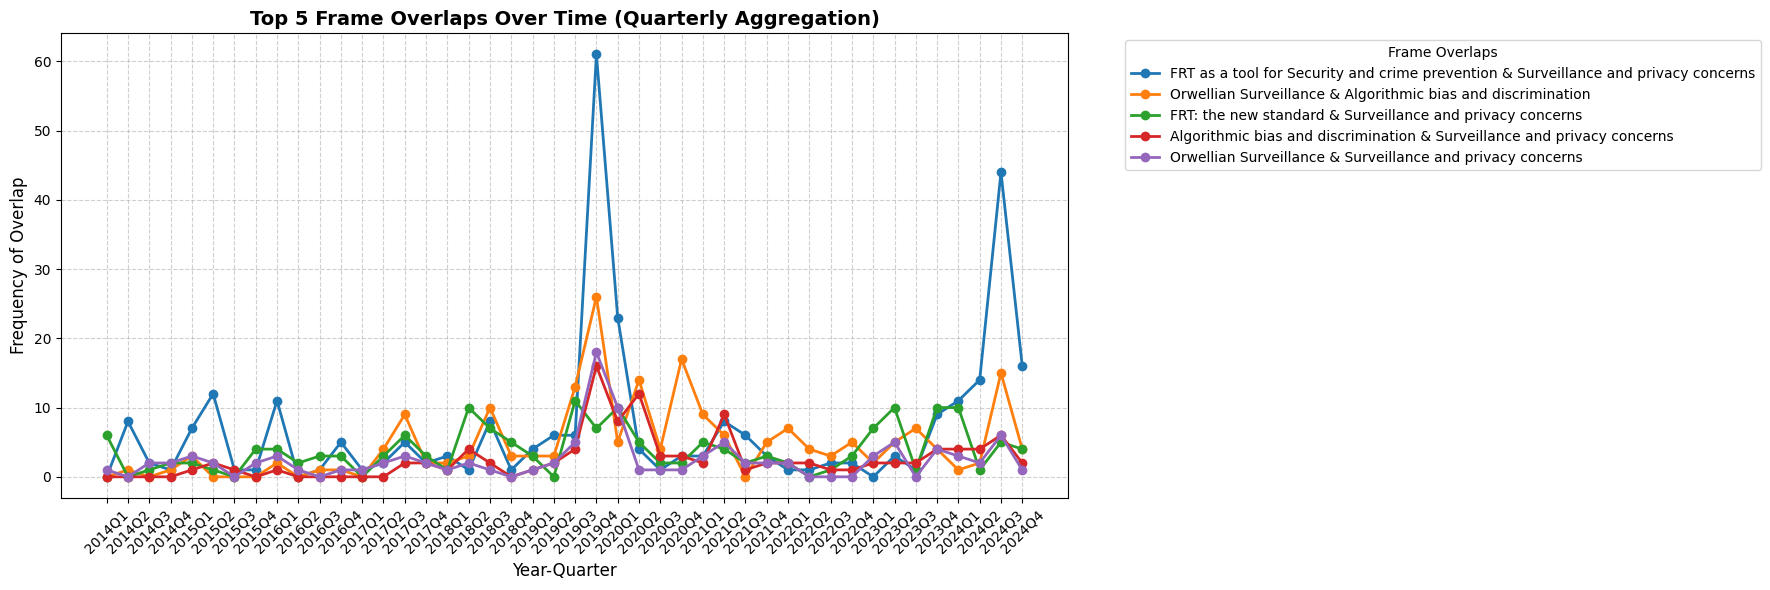

In [8]:
# Aggregate by quarter for better visibility
df_final['year_quarter'] = df_final['date'].dt.to_period('Q')

# Initialize an empty DataFrame to store the time series data
time_series_data_quarterly = pd.DataFrame()

# Calculate the overlap frequencies over time for the top 5 overlaps (aggregated by quarter)
for _, row in top_5_frames.iterrows():
    frame1, frame2 = row['Frame 1'], row['Frame 2']
    overlap_label = f"{frame1} & {frame2}"

    df_final[overlap_label] = (df_final[frame1] == 1) & (df_final[frame2] == 1)
    counts = df_final.groupby('year_quarter')[overlap_label].sum()

    time_series_data_quarterly[overlap_label] = counts

# Plot the data with improved readability
plt.figure(figsize=(18, 6))
for overlap_label in time_series_data_quarterly.columns:
    plt.plot(
        time_series_data_quarterly.index.astype(str),
        time_series_data_quarterly[overlap_label],
        label=overlap_label,
        marker='o',  # Add markers for visibility
        linewidth=2  # Thicker lines
    )

# Customize the plot for better readability
plt.title("Top 5 Frame Overlaps Over Time (Quarterly Aggregation)", fontsize=14, fontweight='bold')
plt.xlabel("Year-Quarter", fontsize=12)
plt.ylabel("Frequency of Overlap", fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # Better visibility of x-axis labels
plt.yticks(fontsize=10)
plt.legend(title="Frame Overlaps", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


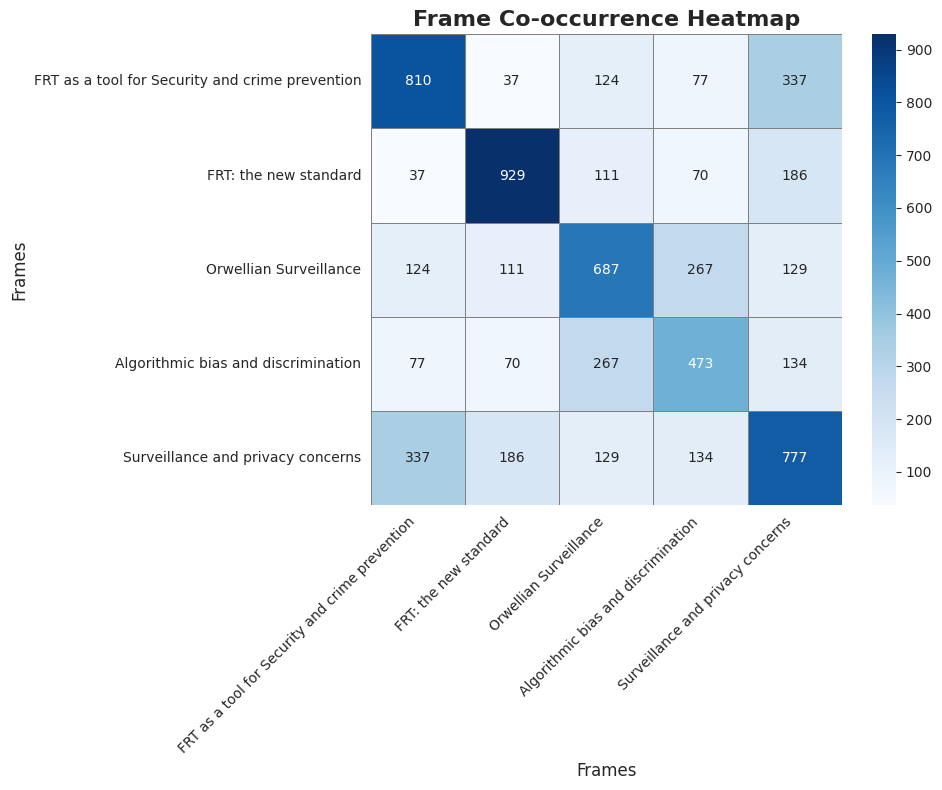

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Frames in your dataset
frames = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

# Create a co-occurrence matrix
# Count how often pairs of frames appear together in the same article
df_final['date'] = pd.to_datetime(df_final['date'], errors='coerce')  # Ensure 'date' is datetime
cooccurrence_matrix = pd.DataFrame(0, index=frames, columns=frames)

for frame_1 in frames:
    for frame_2 in frames:
        cooccurrence_matrix.loc[frame_1, frame_2] = ((df_final[frame_1] == 1) & (df_final[frame_2] == 1)).sum()

# Normalize the matrix to calculate percentages (optional)
normalized_matrix = cooccurrence_matrix.div(cooccurrence_matrix.sum(axis=1), axis=0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cooccurrence_matrix,
    annot=True,  # Show values
    fmt="d",  # Integer format
    cmap="Blues",  # Color map
    cbar=True,
    square=True,
    linewidths=0.5,
    linecolor="gray"
)

# Customize the plot
plt.title('Frame Co-occurrence Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Frames', fontsize=12)
plt.ylabel('Frames', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Checking to see how many of the articles which did not have one of the specified frames:

# columns to check for all zeros
columns_to_check = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

rows_all_zeros = df_final[(df_final[columns_to_check] == 0).all(axis=1)]

len(rows_all_zeros)


235

## RQ2:How has the framing of FRT evolved over time and is it changing with policy developments or external events?

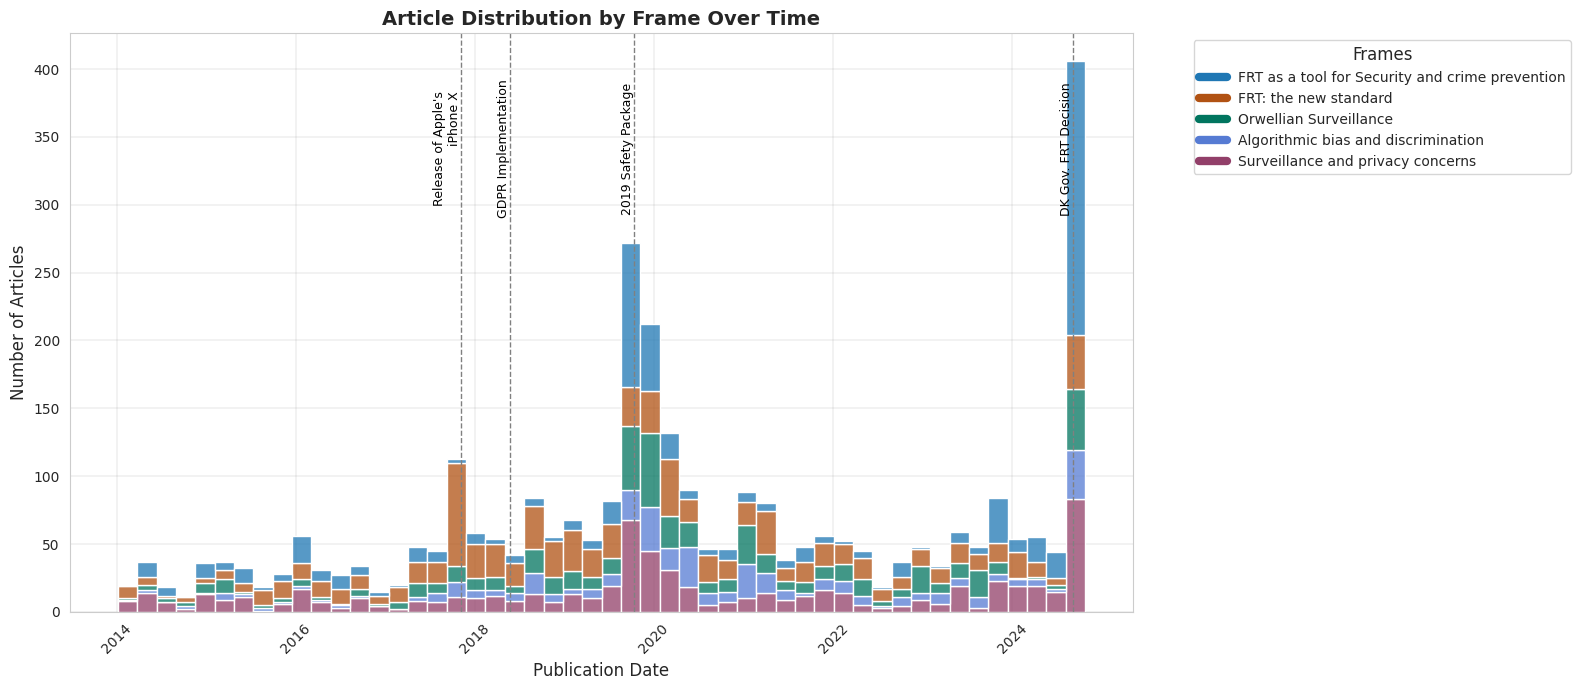

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assign custom colors to each frame (no saturation adjustment)
frame_colors = {
    'FRT as a tool for Security and crime prevention': '#1f77b4',
    'FRT: the new standard': '#b15213',
    'Orwellian Surveillance': '#01755f',
    'Algorithmic bias and discrimination': '#567bd3',
    'Surveillance and privacy concerns': '#923f69'
}

# Attempt to parse dates
df_final['date'] = pd.to_datetime(df_final['date'], errors='coerce')

# Filter valid dates
df_viz = df_final[df_final['date'].notna()]

# Melt the DataFrame to a long format
frames = list(frame_colors.keys())
df_melted = df_viz.melt(
    id_vars=['date'],
    value_vars=frames,
    var_name='Frame',
    value_name='Prediction'
)

# Filter to include only rows where Prediction is 1
df_filtered = df_melted[df_melted['Prediction'] == 1]

# Create the plot
plt.figure(figsize=(16, 7))
histplot = sns.histplot(
    data=df_filtered,
    x='date',
    hue='Frame',
    multiple='stack',
    bins=50,
    kde=False,
    palette=frame_colors  # Use exact custom colors without altering saturation
)

# Add annotations for notable dates
notable_dates = {
    'Release of Apple\'s\niPhone X': '2017-11-03',
    'GDPR Implementation': '2018-05-25',
    '2019 Safety Package': '2019-10-10',
    'DK Gov. FRT Decision': '2024-09-05'
}
for label, date in notable_dates.items():
    date_parsed = pd.to_datetime(date)
    plt.axvline(date_parsed, color='gray', linestyle='--', linewidth=1)
    plt.text(date_parsed, plt.ylim()[1] * 0.8, label, rotation=90,
             verticalalignment='center', horizontalalignment='right', fontsize=9, color='black')

# Add legend manually
plt.legend(
    title='Frames',
    fontsize=10,
    title_fontsize=12,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    labels=list(frame_colors.keys()),
    handles=[plt.Line2D([0], [0], color=color, lw=6) for color in frame_colors.values()]
)

# Customize plot
plt.grid(visible=True, color='gray', linestyle='-', linewidth=0.2, alpha=0.7)
plt.xlabel('Publication Date', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.title('Article Distribution by Frame Over Time', fontsize=14, fontweight='bold')

# Adjust layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Assuming df_final is your DataFrame and 'date' is the column with datetime information
frame_columns = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

# Ensure 'date' column is in datetime format
df_final['date'] = pd.to_datetime(df_final['date'])

# Filter the DataFrame to include rows up until September 2017
filtered_df = df_final[df_final['date'] <= '2016-12-31']

# Calculate the sums for each frame column within the filtered time period
frame_sums = filtered_df[frame_columns].sum()

# Print the occurrences for each frame
for frame_name, occurrences in frame_sums.items():
    print(f"The number of 1's (occurrences) for the frame '{frame_name}' up until September 2017 is: {occurrences}")


The number of 1's (occurrences) for the frame 'FRT as a tool for Security and crime prevention' up until September 2017 is: 100
The number of 1's (occurrences) for the frame 'FRT: the new standard' up until September 2017 is: 111
The number of 1's (occurrences) for the frame 'Orwellian Surveillance' up until September 2017 is: 49
The number of 1's (occurrences) for the frame 'Algorithmic bias and discrimination' up until September 2017 is: 24
The number of 1's (occurrences) for the frame 'Surveillance and privacy concerns' up until September 2017 is: 111


In [20]:
import pandas as pd

# Assuming df_final is your DataFrame and 'date' is the column with datetime information
frame_columns = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

# Ensure 'date' column is in datetime format
df_final['date'] = pd.to_datetime(df_final['date'])

# Filter the DataFrame to include rows up until January 2019
filtered_df = df_final[df_final['date'] <= '2019-01-01']

# Calculate the sums for each frame column within the filtered time period
frame_sums = filtered_df[frame_columns].sum()

# Print the occurrences for each frame
for frame_name, occurrences in frame_sums.items():
    print(f"The number of 1's (occurrences) for the frame '{frame_name}' up until January 2019 is: {occurrences}")


The number of 1's (occurrences) for the frame 'FRT as a tool for Security and crime prevention' up until January 2019 is: 153
The number of 1's (occurrences) for the frame 'FRT: the new standard' up until January 2019 is: 358
The number of 1's (occurrences) for the frame 'Orwellian Surveillance' up until January 2019 is: 140
The number of 1's (occurrences) for the frame 'Algorithmic bias and discrimination' up until January 2019 is: 83
The number of 1's (occurrences) for the frame 'Surveillance and privacy concerns' up until January 2019 is: 191


In [3]:
import pandas as pd

# Assuming df_final is your DataFrame and 'date' is the column with datetime information
frame_columns = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

# Ensure 'date' column is in datetime format
df_final['date'] = pd.to_datetime(df_final['date'])

# Filter the DataFrame to include rows after January 2019
filtered_df = df_final[df_final['date'] >= '2019-01-01']

# Calculate the sums for each frame column within the filtered time period
frame_sums = filtered_df[frame_columns].sum()

# Print the occurrences for each frame
for frame_name, occurrences in frame_sums.items():
    print(f"The number of 1's (occurrences) for the frame '{frame_name}' after January 2019 is: {occurrences}")


The number of 1's (occurrences) for the frame 'FRT as a tool for Security and crime prevention' after January 2019 is: 577
The number of 1's (occurrences) for the frame 'FRT: the new standard' after January 2019 is: 503
The number of 1's (occurrences) for the frame 'Orwellian Surveillance' after January 2019 is: 413
The number of 1's (occurrences) for the frame 'Algorithmic bias and discrimination' after January 2019 is: 298
The number of 1's (occurrences) for the frame 'Surveillance and privacy concerns' after January 2019 is: 498


In [16]:
import pandas as pd

# Assuming df_final is your DataFrame and 'date' is the column with datetime information
frame_columns = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

# Ensure 'date' column is in datetime format
df_final['date'] = pd.to_datetime(df_final['date'])

# Filter the DataFrame to include rows up until September 2017
filtered_df = df_final[df_final['date'] >= '2021-01-01']

# Calculate the sums for each frame column within the filtered time period
frame_sums = filtered_df[frame_columns].sum()

# Print the occurrences for each frame
for frame_name, occurrences in frame_sums.items():
    print(f"The number of 1's (occurrences) for the frame '{frame_name}' up until September 2017 is: {occurrences}")


The number of 1's (occurrences) for the frame 'FRT as a tool for Security and crime prevention' up until September 2017 is: 351
The number of 1's (occurrences) for the frame 'FRT: the new standard' up until September 2017 is: 272
The number of 1's (occurrences) for the frame 'Orwellian Surveillance' up until September 2017 is: 204
The number of 1's (occurrences) for the frame 'Algorithmic bias and discrimination' up until September 2017 is: 146
The number of 1's (occurrences) for the frame 'Surveillance and privacy concerns' up until September 2017 is: 280


<ipython-input-9-62b362f6c104>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_viz['month'] = df_viz['date'].dt.to_period('M')  # Convert to monthly periods
<ipython-input-9-62b362f6c104>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_viz['all_frames_zero'] = df_viz[frames].sum(axis=1) == 0  # Create a column for rows where all frames are zero
<ipython-input-9-62b362f6c104>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Total number of rows with 0 in all frames: 203


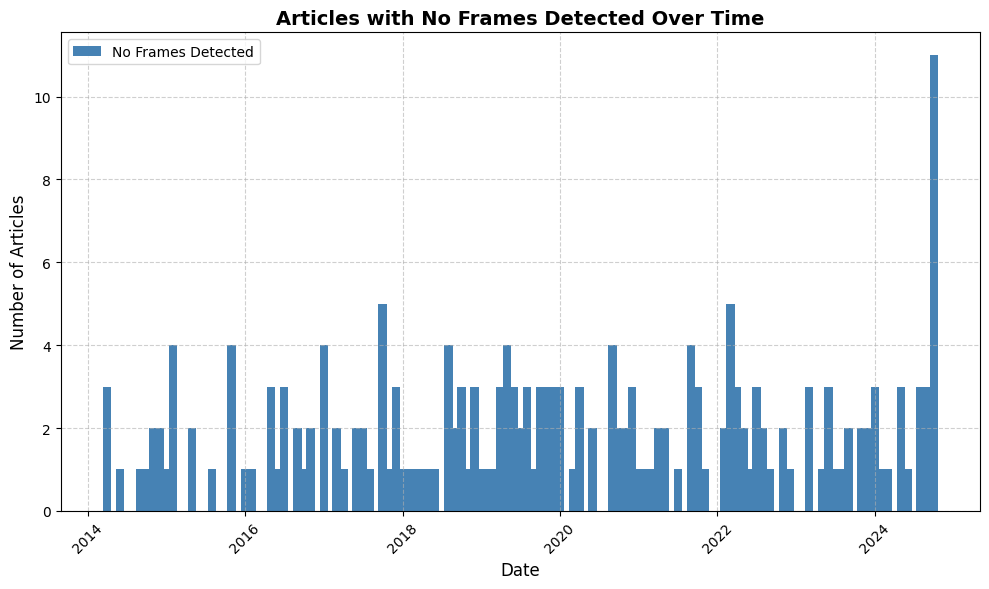

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Parse dates and filter valid ones
df_final['date'] = pd.to_datetime(df_final['date'], errors='coerce')
df_viz = df_final[df_final['date'].notna()]
df_viz['month'] = df_viz['date'].dt.to_period('M')  # Convert to monthly periods

# Filter rows where all frames have 0
frames = ['FRT as a tool for Security and crime prevention', 'FRT: the new standard', 'Orwellian Surveillance', 'Algorithmic bias and discrimination', 'Surveillance and privacy concerns']  # Replace with your frame column names
df_viz['all_frames_zero'] = df_viz[frames].sum(axis=1) == 0  # Create a column for rows where all frames are zero
df_zero_frames = df_viz[df_viz['all_frames_zero']]

# Count total rows with 0 in all frames
total_zero_frames = df_zero_frames.shape[0]
print(f"Total number of rows with 0 in all frames: {total_zero_frames}")

# Group by month for counts
df_zero_frames['month'] = df_zero_frames['date'].dt.to_period('M')  # Convert to monthly periods
df_zero_monthly = df_zero_frames.groupby(['month']).size().reset_index(name='count')
df_zero_monthly['month'] = df_zero_monthly['month'].dt.to_timestamp()  # Convert back to timestamps for plotting

# Bar plot for counts over time
plt.figure(figsize=(10, 6))
plt.bar(df_zero_monthly['month'], df_zero_monthly['count'], color='steelblue', width=40, label='No Frames Detected')  # Wider bins
plt.title('Articles with No Frames Detected Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


<ipython-input-11-0259402d018b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_viz['month'] = df_viz['date'].dt.to_period('M')  # Convert to monthly periods
<ipython-input-11-0259402d018b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_viz['all_frames_zero'] = df_viz[list(frame_colors.keys())].sum(axis=1) == 0
<ipython-input-11-0259402d018b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

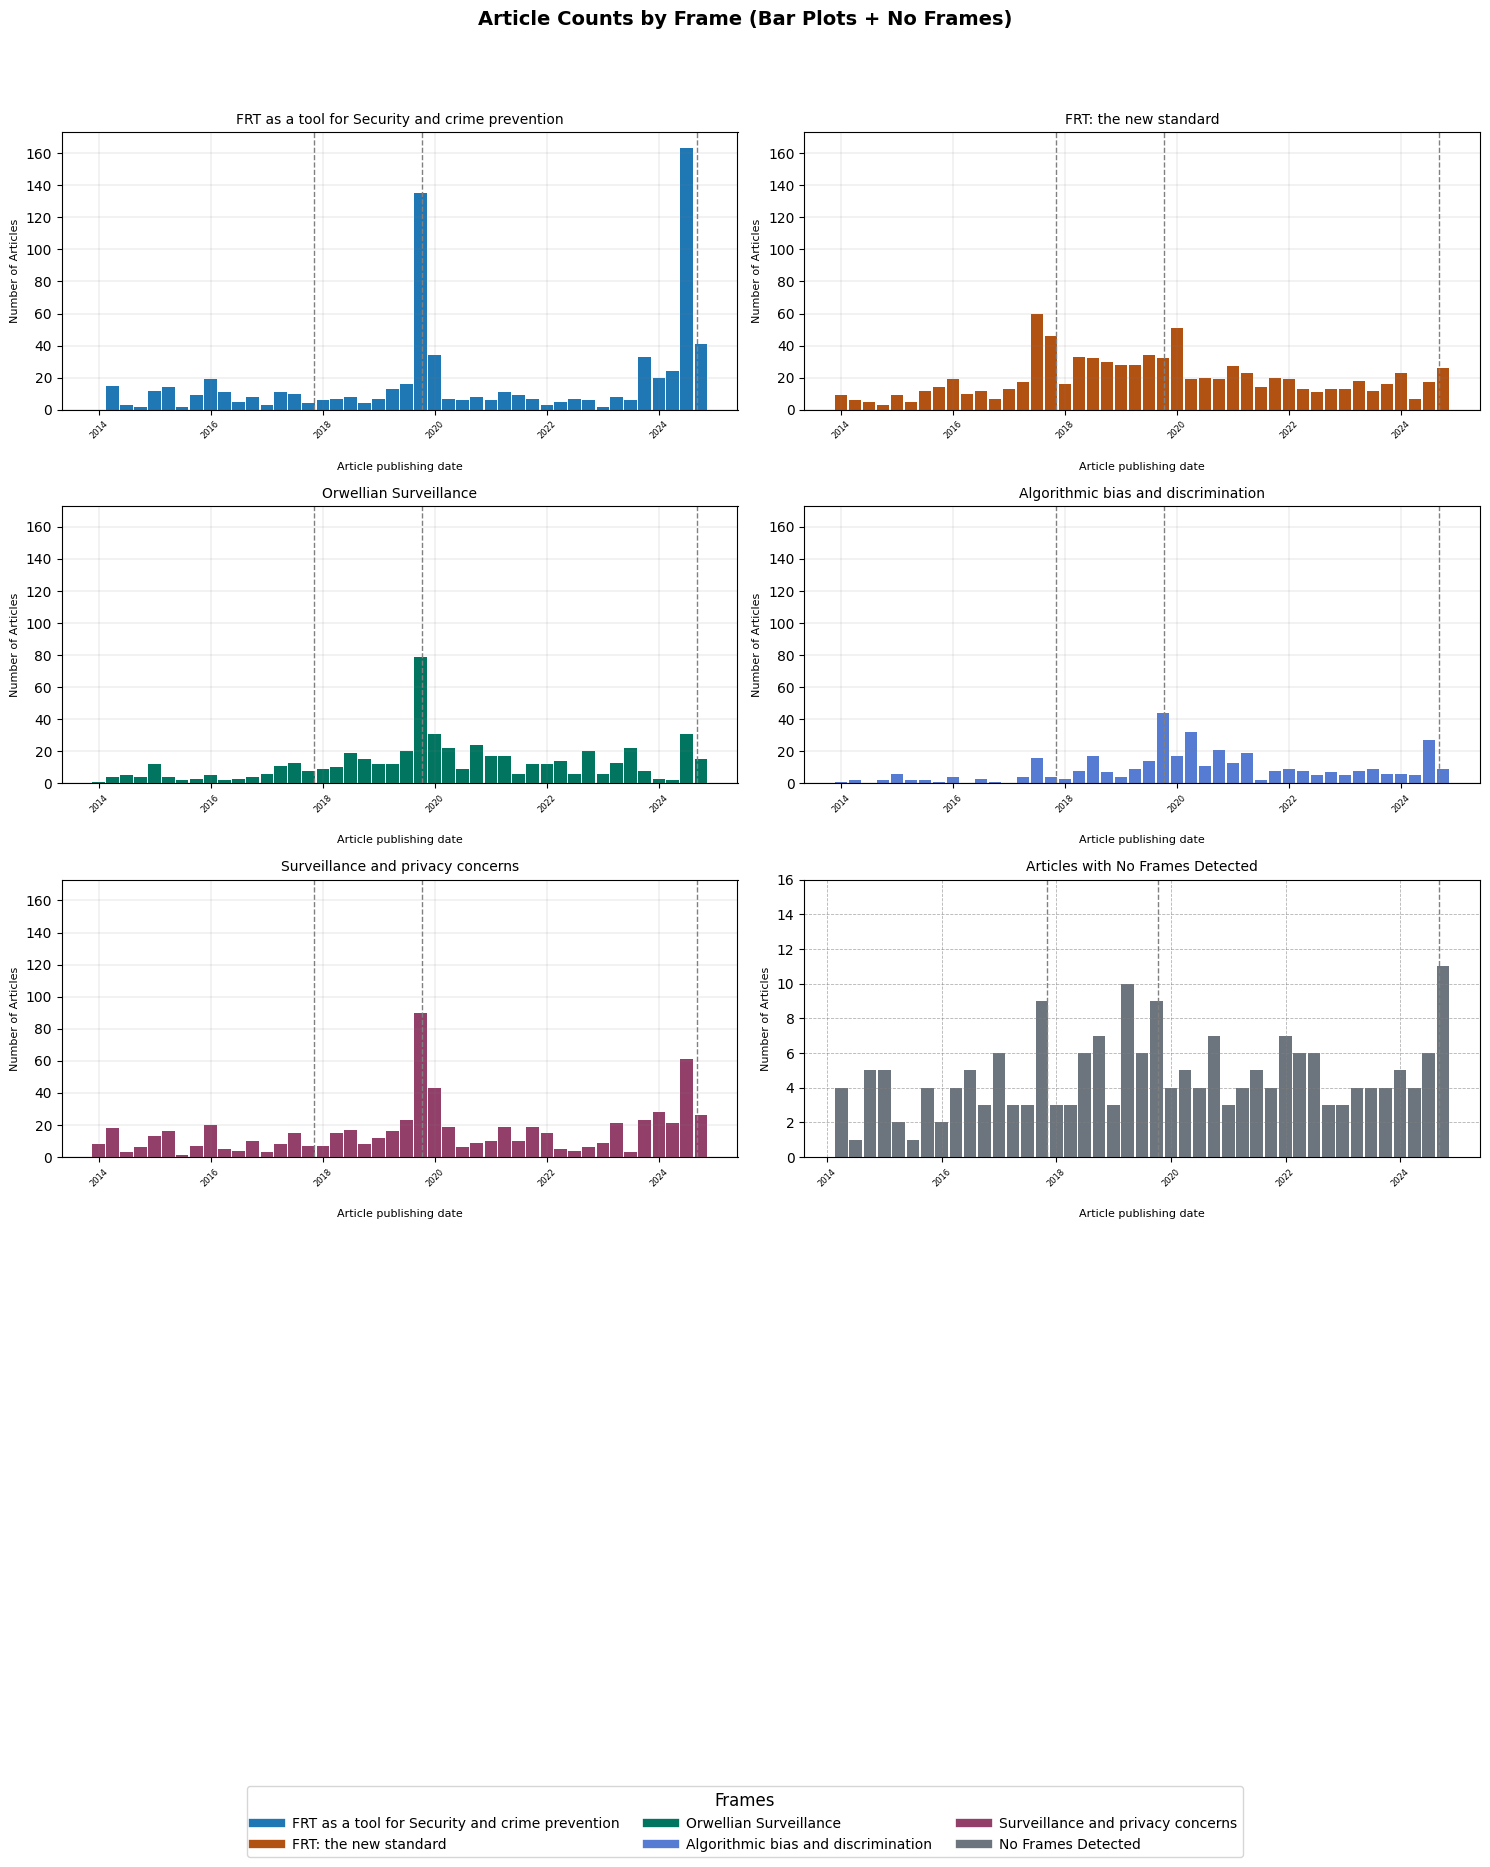

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assign custom colors to each frame
frame_colors = {
    'FRT as a tool for Security and crime prevention': '#1f77b4',
    'FRT: the new standard': '#b15213',
    'Orwellian Surveillance': '#01755f',
    'Algorithmic bias and discrimination': '#567bd3',
    'Surveillance and privacy concerns': '#923f69'
}

# Group data by month for counts
df_viz['month'] = df_viz['date'].dt.to_period('M')  # Convert to monthly periods
df_monthly = df_viz.groupby(['month'])[list(frame_colors.keys())].sum().reset_index()
df_monthly['month'] = df_monthly['month'].dt.to_timestamp()  # Convert back to timestamps for plotting

# Define larger bins for aggregation (e.g., group by year or quarter)
df_monthly['bin'] = df_monthly['month'].dt.to_period('Q')  # Group by quarter
df_binned = df_monthly.groupby(['bin'])[list(frame_colors.keys())].sum().reset_index()
df_binned['bin'] = df_binned['bin'].dt.to_timestamp()  # Convert back to timestamps for plotting

# Prepare data for rows with 0 in all frames
df_viz['all_frames_zero'] = df_viz[list(frame_colors.keys())].sum(axis=1) == 0
df_zero_frames = df_viz[df_viz['all_frames_zero']]
df_zero_frames['bin'] = df_zero_frames['date'].dt.to_period('Q')  # Group to the same bin size (quarterly)
df_zero_binned = df_zero_frames.groupby(['bin']).size().reset_index(name='count')
df_zero_binned['bin'] = df_zero_binned['bin'].dt.to_timestamp()  # Convert back to timestamps for plotting

# Create subplots in a grid layout (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18), sharey=False)  # Individual y-axes
axes = axes.flatten()

# Calculate max y-axis value for consistent scaling in the shared y-axis plots
max_y = df_binned[list(frame_colors.keys())].max().max()

# Plot bar plots for individual frames
for ax, (frame, color) in zip(axes[:-1], frame_colors.items()):  # Leave the last axis for 'No Frames Detected' plot
    ax.bar(df_binned['bin'], df_binned[frame], label=frame, color=color, width=80)  # Larger bins
    ax.set_title(frame, fontsize=10)
    ax.set_xlabel('Article publishing date', fontsize=8, labelpad=15)  # Updated label
    ax.set_ylabel('Number of Articles', fontsize=8)
    ax.set_ylim(0, max_y + 10)  # Consistent y-axis for shared plots
    ax.tick_params(axis='x', rotation=45, labelsize=6)  # Smaller tick text
    ax.grid(visible=True, color='gray', linestyle='-', linewidth=0.2, alpha=0.7)

# Plot the 'No Frames Detected' data in the last subplot
axes[-1].bar(df_zero_binned['bin'], df_zero_binned['count'], color='#6c757d', width=80, label='No Frames Detected')  # Matches bin size
axes[-1].set_title('Articles with No Frames Detected', fontsize=10)
axes[-1].set_xlabel('Article publishing date', fontsize=8, labelpad=15)  # Updated label
axes[-1].set_ylabel('Number of Articles', fontsize=8)
axes[-1].set_ylim(0, 16)  # Set y-axis limit to 15
axes[-1].tick_params(axis='x', rotation=45, labelsize=6)
axes[-1].grid(visible=True, color='gray', linestyle='--', linewidth=0.6, alpha=0.6)


# Add vertical lines for notable dates
notable_dates = {
    'Release of Apple\'s\niPhone X': '2017-11-03',
    '2019 Safety Package': '2019-10-10',
    'DK Gov. FRT Decision': '2024-09-05'
}

for date in notable_dates.values():
    date_parsed = pd.to_datetime(date)
    for ax in axes:
        ax.axvline(date_parsed, color='gray', linestyle='--', linewidth=1)

# Add legend below the entire figure
handles = [plt.Line2D([0], [0], color=color, lw=6) for color in frame_colors.values()]
handles.append(plt.Line2D([0], [0], color='#6c757d', lw=6))  # Add 'No Frames Detected' to the legend
fig.legend(
    handles,
    list(frame_colors.keys()) + ['No Frames Detected'],
    loc='lower center',
    fontsize=10,
    title="Frames",
    title_fontsize=12,
    ncol=3,
    bbox_to_anchor=(0.5, -0.05)  # Adjust to position below the figure
)

# Adjust layout to prevent overlap
fig.subplots_adjust(bottom=0.3)  # Make space for the legend
fig.suptitle('Article Counts by Frame (Bar Plots + No Frames)', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.3, 1, 0.95])  # Adjust layout to make room for the legend
plt.show()


In [20]:
!ls '/content/gdrive/My Drive/Thesis/lmroman7-regular.otf'


'/content/gdrive/My Drive/Thesis/lmroman7-regular.otf'


In [26]:
!pip install --upgrade matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


In [19]:
# prompt: count all rows which do not have a value in 'date'

# Count rows where 'date' is missing
missing_dates_count = df_final['date'].isnull().sum()
print(f"Number of rows without a valid 'date': {missing_dates_count}")

Number of rows without a valid 'date': 320


<ipython-input-53-d5a3dfe4a799>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_viz['month'] = df_viz['date'].dt.to_period('M')  # Convert to monthly periods
<ipython-input-53-d5a3dfe4a799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_viz['all_frames_zero'] = df_viz[list(frame_colors.keys())].sum(axis=1) == 0
<ipython-input-53-d5a3dfe4a799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

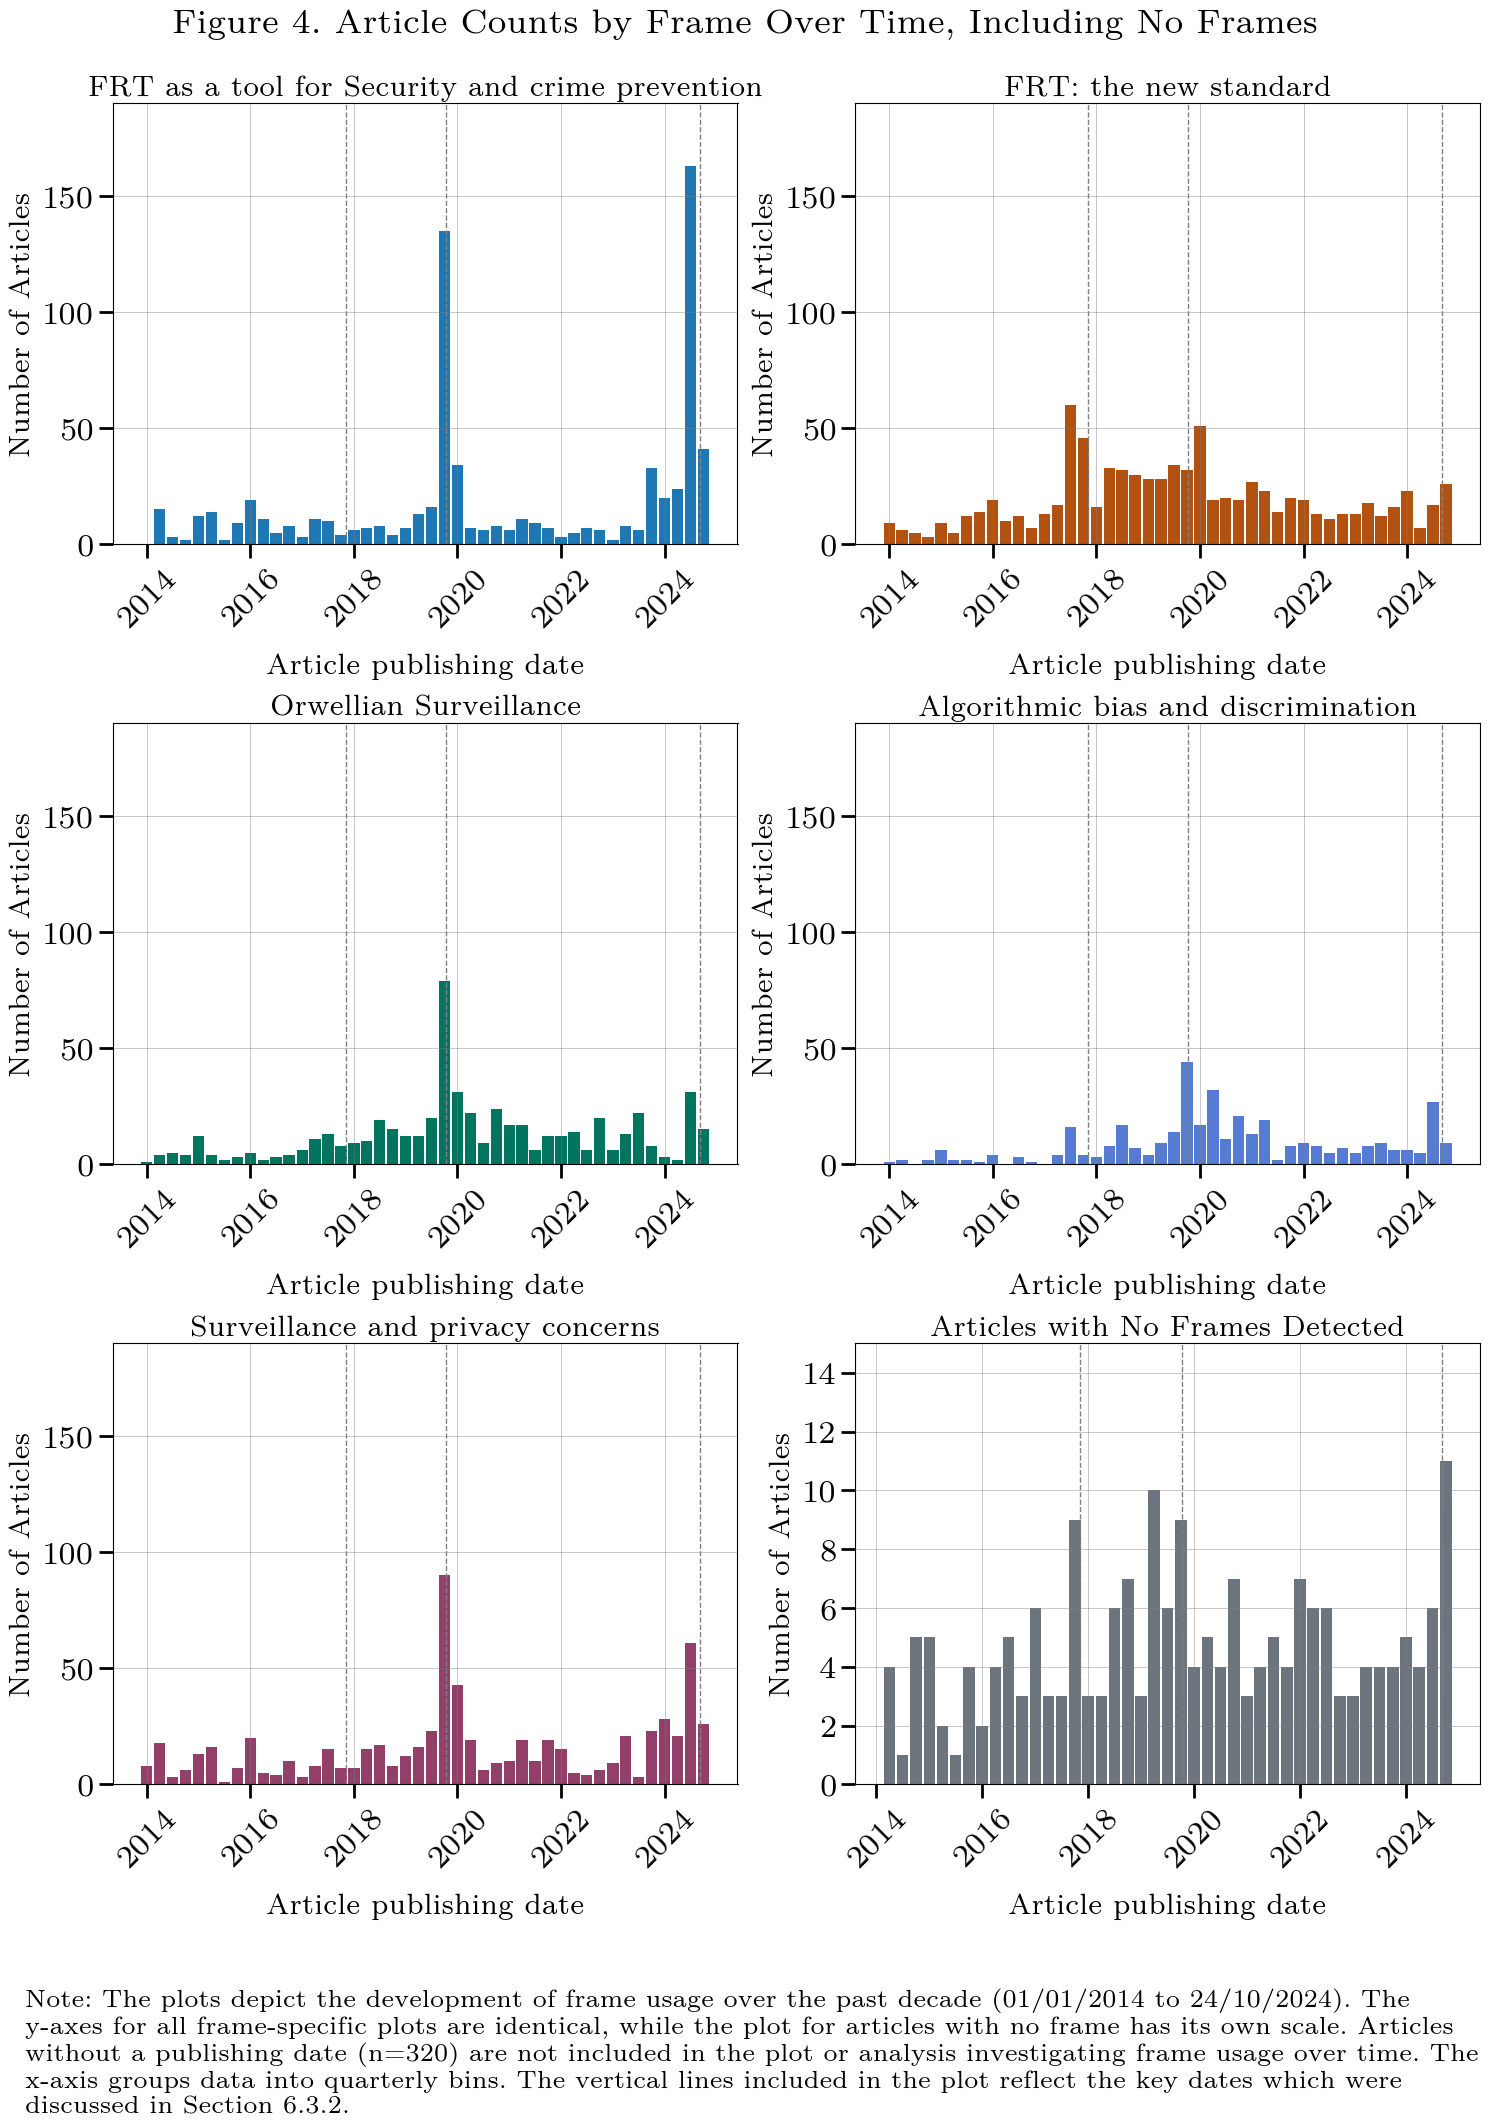

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import font_manager as fm

# Load custom fonts
regular_font_path = '/content/gdrive/My Drive/Thesis/lmroman7-regular.otf' #bc nice
regular_font = fm.FontProperties(fname=regular_font_path)

# Assign custom colors to each frame
frame_colors = {
    'FRT as a tool for Security and crime prevention': '#1f77b4',
    'FRT: the new standard': '#b15213',
    'Orwellian Surveillance': '#01755f',
    'Algorithmic bias and discrimination': '#567bd3',
    'Surveillance and privacy concerns': '#923f69'
}

# Group data by month for counts
df_final['date'] = pd.to_datetime(df_final['date'], errors='coerce')
df_viz = df_final[df_final['date'].notna()]
df_viz['month'] = df_viz['date'].dt.to_period('M')  # Convert to monthly periods
df_monthly = df_viz.groupby(['month'])[list(frame_colors.keys())].sum().reset_index()
df_monthly['month'] = df_monthly['month'].dt.to_timestamp()  # Convert back to timestamps for plotting

# Define larger bins for aggregation (e.g., group by year or quarter)
df_monthly['bin'] = df_monthly['month'].dt.to_period('Q')  # Group by quarter
df_binned = df_monthly.groupby(['bin'])[list(frame_colors.keys())].sum().reset_index()
df_binned['bin'] = df_binned['bin'].dt.to_timestamp()  # Convert back to timestamps for plotting

# Prepare data for rows with 0 in all frames
df_viz['all_frames_zero'] = df_viz[list(frame_colors.keys())].sum(axis=1) == 0
df_zero_frames = df_viz[df_viz['all_frames_zero']]
df_zero_frames['bin'] = df_zero_frames['date'].dt.to_period('Q')  # Group to the same bin size (quarterly)
df_zero_binned = df_zero_frames.groupby(['bin']).size().reset_index(name='count')
df_zero_binned['bin'] = df_zero_binned['bin'].dt.to_timestamp()  # Convert back to timestamps for plotting

# Create subplots in a grid layout (3 rows x 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 25), sharey=False)  # Individual y-axes
axes = axes.flatten()

# Define y-axis limit for individual plots
individual_plot_ylim = 180  # Consistent y-axis for all individual plots

# Explicitly set larger font sizes for ticks
for ax, (frame, color) in zip(axes[:-1], frame_colors.items()):  # Leave the last axis for 'No Frames Detected' plot
    ax.bar(df_binned['bin'], df_binned[frame], label=frame, color=color, width=80)  # Larger bins
    # Set consistent y-axis limit for individual plots
    ax.set_ylim(0, individual_plot_ylim)
    # Set the title with the updated font size and properties
    ax.set_title(frame, fontproperties=regular_font, fontsize=20)  # Explicitly use FontProperties and increase size
    ax.set_xlabel('Article publishing date', fontsize=20, labelpad=15, fontproperties=regular_font)  # Updated label
    ax.set_ylabel('Number of Articles', fontsize=20, fontproperties=regular_font)
    # Customize tick parameters for size and font
    ax.tick_params(axis='x', rotation=45, labelsize=22, width=2, length=10)  # Increased tick label size and width
    ax.tick_params(axis='y', labelsize=22, width=2, length=10)
    # Apply the custom font to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(regular_font)
        label.set_fontsize(22)  # Explicitly set font size for all tick labels
    ax.grid(visible=True, color='gray', linestyle='-', linewidth=0.5, alpha=0.6)  # Restore grid lines

# For the last plot ('No Frames Detected')
axes[-1].bar(df_zero_binned['bin'], df_zero_binned['count'], color='#6c757d', width=80, label='No Frames Detected')
axes[-1].set_title('Articles with No Frames Detected', fontproperties=regular_font, fontsize=20)  # Title consistent
axes[-1].set_xlabel('Article publishing date', fontsize=20, labelpad=15, fontproperties=regular_font)  # X-label
axes[-1].set_ylabel('Number of Articles', fontsize=20, fontproperties=regular_font)  # Y-label
axes[-1].tick_params(axis='x', rotation=45, labelsize=22, width=2, length=10)  # Tick labels consistent
axes[-1].tick_params(axis='y', labelsize=22, width=2, length=10)
axes[-1].set_ylim(0, 15)  # Set y-axis limit to 15 for the no-frames plot
# Apply the font to tick labels
for label in axes[-1].get_xticklabels() + axes[-1].get_yticklabels():
    label.set_fontproperties(regular_font)
    label.set_fontsize(22)  # Explicitly set font size for all tick labels
axes[-1].grid(visible=True, color='gray', linestyle='-', linewidth=0.5, alpha=0.6)  # Restore grid lines
# Remove decimals from y-axis ticks
axes[-1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Set integer-only ticks



# Add vertical lines for notable dates
notable_dates = {
    'Release of Apple\'s\niPhone X': '2017-11-03',
    '2019 Safety Package': '2019-10-10',
    'DK Gov. FRT Decision': '2024-09-05'
}

for date in notable_dates.values():
    date_parsed = pd.to_datetime(date)
    for ax in axes:
        ax.axvline(date_parsed, color='gray', linestyle='--', linewidth=1)

# Adjust layout to ensure better spacing
fig.subplots_adjust(bottom=0.35, wspace=0.4, hspace=1.2)  # Increase hspace for more vertical spacing
plt.tight_layout(rect=[0, 0.2, 1, 0.95])  # Reduce bottom space to bring everything closer
fig.suptitle('Figure 4. Article Counts by Frame Over Time, Including No Frames', fontsize=24, fontproperties=regular_font, y=0.97)

# Add a note under the graph, aligned to the left
plt.figtext(
    0.02, 0.13,  # Position: x=0.02 (left-aligned), y=0.02 (closer to the plot)
    "Note: The plots depict the development of frame usage over the past decade (01/01/2014 to 24/10/2024). The y-axes for all frame-specific plots are identical, while the plot for articles with no frame has its own scale. Articles without a publishing date (n=320) are not included in the plot or analysis investigating frame usage over time. The x-axis groups data into quarterly bins. The vertical lines included in the plot reflect the key dates which were discussed in Section 6.3.2.",
    wrap=True, horizontalalignment='left', fontsize=18, color='black', fontproperties=regular_font
)

plt.show()


## RQ3: How does the coverage of of facial recognition technology differ according to partisan leaning of the media outlet?


In [6]:
# Update political_orientation to "right-leaning" for rows where source is "Jydske Vestkysten"
df_final.loc[df_final['source'] == 'Jydske Vestkysten', 'political_orientation'] = 'Right-leaning'

# Verify the changes
print(df_final[df_final['source'] == 'Jydske Vestkysten']['political_orientation'].unique())


['Right-leaning']


In [7]:
import pandas as pd

# Count occurrences for each political orientation
orientation_counts = df_final['political_orientation'].value_counts()

# Calculate percentages
orientation_percentages = (orientation_counts / orientation_counts.sum()) * 100

# Create a DataFrame for display
orientation_table = pd.DataFrame({
    'Political Orientation': orientation_counts.index,
    'Count': orientation_counts.values,
    'Percentage (%)': orientation_percentages.values
})

# Reset index for a cleaner table
orientation_table.reset_index(drop=True, inplace=True)

# Print the table
print(orientation_table)

# Optionally, save the table to a CSV file if needed
# orientation_table.to_csv('political_orientation_counts.csv', index=False)


               Political Orientation  Count  Percentage (%)
0                      Right-leaning    783       29.216418
1  Technology-focused, non-political    605       22.574627
2                       Left-leaning    598       22.313433
3                            Neutral    437       16.305970
4     Finance-focused, non-political    204        7.611940
5                           Centrist     53        1.977612


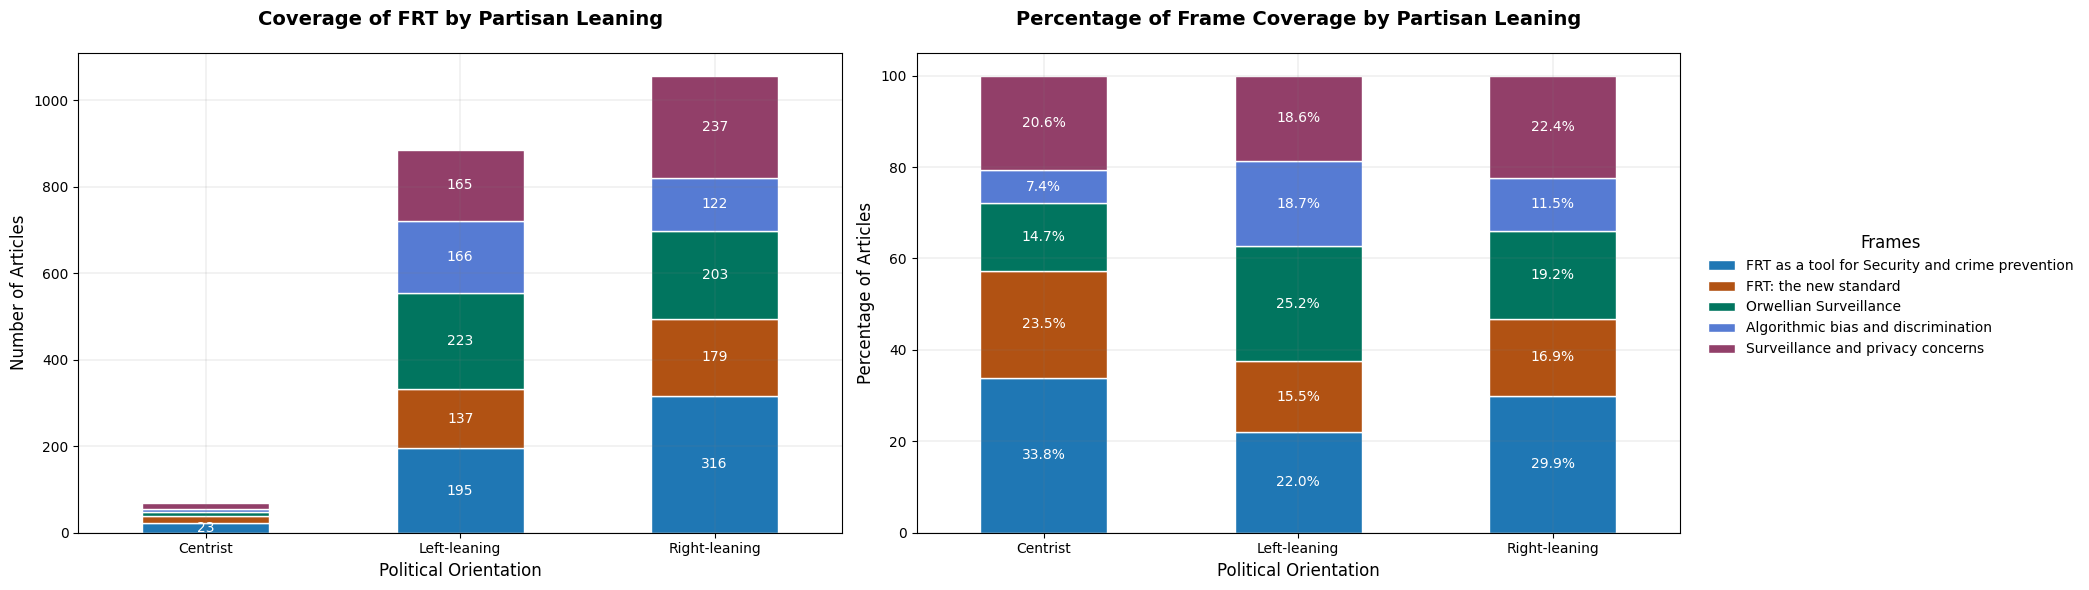

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Define colors for the frames
frame_colors = ['#1f77b4', '#b15213', '#01755f', '#567bd3', '#923f69']

# Filter only centrist, right-leaning, and left-leaning outlets
filtered_orientations = ['Centrist', 'Right-leaning', 'Left-leaning']
df_filtered = df_final[df_final['political_orientation'].isin(filtered_orientations)]

# Group data by political orientation and sum the frame occurrences
frames = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

coverage_by_orientation = df_filtered.groupby('political_orientation')[frames].sum()

# Normalize the data to get percentages (for proportional comparison)
coverage_percentage = coverage_by_orientation.div(coverage_by_orientation.sum(axis=1), axis=0) * 100

# Define new political orientation labels with line breaks
formatted_labels = {
    'Centrist': 'Centrist',
    'Right-leaning': 'Right-leaning',
    'Left-leaning': 'Left-leaning'
}

# Replace index with formatted labels
coverage_by_orientation.index = coverage_by_orientation.index.map(formatted_labels)
coverage_percentage.index = coverage_percentage.index.map(formatted_labels)

# Initialize the subplots
fig, axes = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'width_ratios': [3, 3]}, sharey=False)

# Plot absolute values
coverage_by_orientation.plot(
    kind='bar',
    stacked=True,
    ax=axes[0],
    color=frame_colors,
    edgecolor='white',  # Change edge color to white
    legend=False  # Disable individual legend
)
axes[0].set_title('Coverage of FRT by Partisan Leaning', fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Political Orientation', fontsize=12)
axes[0].set_ylabel('Number of Articles', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)  # Horizontal labels
axes[0].grid(visible=True, color='gray', linestyle='-', linewidth=0.2, alpha=0.7)  # Add grid

# Add values inside the bars for absolute counts
for container in axes[0].containers:
    labels = [f'{int(val)}' if val > 20 else '' for val in container.datavalues]  # Only show if value > 20
    axes[0].bar_label(container, labels=labels, label_type='center', color='white', fontsize=10)

# Plot percentages
coverage_percentage.plot(
    kind='bar',
    stacked=True,
    ax=axes[1],
    color=frame_colors,
    edgecolor='white',  # Change edge color to white
    legend=False  # Disable individual legend
)
axes[1].set_title('Percentage of Frame Coverage by Partisan Leaning', fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Political Orientation', fontsize=12)
axes[1].set_ylabel('Percentage of Articles', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)  # Horizontal labels
axes[1].grid(visible=True, color='gray', linestyle='-', linewidth=0.2, alpha=0.7)  # Add grid

# Add values inside the bars for percentages
for container in axes[1].containers:
    labels = [f'{val:.1f}%' if val > 5 else '' for val in container.datavalues]  # Only show if value > 5%
    axes[1].bar_label(container, labels=labels, label_type='center', color='white', fontsize=10)

# Add a shared legend to the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title='Frames', title_fontsize=12, frameon=False
)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space at the right for the shared legend
plt.show()


In [11]:

from IPython.display import display

# Filter only the desired orientations
filtered_orientations = ['Centrist', 'Right-leaning', 'Left-leaning']
df_filtered = df_final[df_final['political_orientation'].isin(filtered_orientations)]



# Group data by political orientation and sum the frame occurrences
frames = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

coverage_by_orientation = df_filtered.groupby('political_orientation')[frames].sum()

# Transpose the DataFrame so frames are rows and orientations are columns
coverage_transposed = coverage_by_orientation.T
coverage_transposed.columns = [formatted_labels[col] for col in coverage_transposed.columns]  # Format column labels

# Display the results
display(coverage_transposed)


Centrist  Left-leaning  \
FRT as a tool for Security and crime prevention        23           195   
FRT: the new standard                                  16           137   
Orwellian Surveillance                                 10           223   
Algorithmic bias and discrimination                     5           166   
Surveillance and privacy concerns                      14           165   

                                                 Right-leaning  
FRT as a tool for Security and crime prevention            316  
FRT: the new standard                                      179  
Orwellian Surveillance                                     203  
Algorithmic bias and discrimination                        122  
Surveillance and privacy concerns                          237

In [18]:
# Create the "Others" category
df_final['political_orientation_cleaned'] = df_final['political_orientation'].apply(
    lambda x: x if x in ['Centrist', 'Left-leaning', 'Right-leaning'] else 'Others'
)

# Group data by political orientation
coverage_by_orientation = df_final.groupby('political_orientation_cleaned')[frames].sum()

# Normalize to calculate percentages
coverage_percentage = coverage_by_orientation.div(coverage_by_orientation.sum(axis=0), axis=1) * 100

# Combine absolute and percentage data
coverage_combined = pd.concat([coverage_by_orientation, coverage_percentage], axis=1, keys=['Count', 'Percentage'])

# Reformat the data for the desired layout (Frames as rows and Political Orientations as columns)

# Transpose the DataFrame to make frames the rows
coverage_transposed = coverage_combined.T.swaplevel(axis=0).sort_index(level=0, axis=1)


coverage_transposed


political_orientation_cleaned                                Centrist  \
FRT as a tool for Security and crime prevention Count       23.000000   
FRT: the new standard                           Count       16.000000   
Orwellian Surveillance                          Count       10.000000   
Algorithmic bias and discrimination             Count        5.000000   
Surveillance and privacy concerns               Count       14.000000   
FRT as a tool for Security and crime prevention Percentage   2.839506   
FRT: the new standard                           Percentage   1.722282   
Orwellian Surveillance                          Percentage   1.455604   
Algorithmic bias and discrimination             Percentage   1.057082   
Surveillance and privacy concerns               Percentage   1.801802   

political_orientation_cleaned                               Left-leaning  \
FRT as a tool for Security and crime prevention Count         195.000000   
FRT: the new standard                           Count         137.000000   
Orwellian Surveillance                          Count         223.000000   
Algorithmic bias and discrimination             Count         166.000000   
Surveillance and privacy concerns               Count         165.000000   
FRT as a tool for Security and crime prevention Percentage     24.074074   
FRT: the new standard                           Percentage     14.747040   
Orwellian Surveillance                          Percentage     32.459971   
Algorithmic bias and discrimination             Percentage     35.095137   
Surveillance and privacy concerns               Percentage     21.235521   

political_orientation_cleaned                                   Others  \
FRT as a tool for Security and crime prevention Count       276.000000   
FRT: the new standard                           Count       597.000000   
Orwellian Surveillance                          Count       251.000000   
Algorithmic bias and discrimination             Count       180.000000   
Surveillance and privacy concerns               Count       361.000000   
FRT as a tool for Security and crime prevention Percentage   34.074074   
FRT: the new standard                           Percentage   64.262648   
Orwellian Surveillance                          Percentage   36.535662   
Algorithmic bias and discrimination             Percentage   38.054968   
Surveillance and privacy concerns               Percentage   46.460746   

political_orientation_cleaned                               Right-leaning  
FRT as a tool for Security and crime prevention Count          316.000000  
FRT: the new standard                           Count          179.000000  
Orwellian Surveillance                          Count          203.000000  
Algorithmic bias and discrimination             Count          122.000000  
Surveillance and privacy concerns               Count          237.000000  
FRT as a tool for Security and crime prevention Percentage      39.012346  
FRT: the new standard                           Percentage      19.268030  
Orwellian Surveillance                          Percentage      29.548763  
Algorithmic bias and discrimination             Percentage      25.792812  
Surveillance and privacy concerns               Percentage      30.501931

In [26]:
frame_counts

FRT as a tool for Security and crime prevention  \
political_orientation_cleaned                                                    
Centrist                                                                    23   
Left-leaning                                                               195   
Others                                                                     276   
Right-leaning                                                              316   

                               FRT: the new standard  Orwellian Surveillance  \
political_orientation_cleaned                                                  
Centrist                                          16                      10   
Left-leaning                                     137                     223   
Others                                           597                     251   
Right-leaning                                    179                     203   

                               Algorithmic bias and discrimination  \
political_orientation_cleaned                                        
Centrist                                                         5   
Left-leaning                                                   166   
Others                                                         180   
Right-leaning                                                  122   

                               Surveillance and privacy concerns  
political_orientation_cleaned                                     
Centrist                                                      14  
Left-leaning                                                 165  
Others                                                       361  
Right-leaning                                                237

In [29]:
# Define which political orientations are considered as "Others"
valid_orientations = ["Centrist", "Left-leaning", "Right-leaning"]

# Assign "Others" to all rows not in the valid orientations
df_final["political_orientation_cleaned"] = df_final["political_orientation_cleaned"].apply(
    lambda x: x if x in valid_orientations else "Others"
)


# Compute the counts for each frame by political orientation
frame_counts = df_final.groupby("political_orientation_cleaned")[frames].sum()

# Calculate total counts for all frames across all orientations
grand_total_count = frame_counts.values.sum()

# Calculate percentages for each frame across all orientations
total_percentages = frame_counts.sum(axis=0) / grand_total_count * 100

# Reformat the data to include both counts and percentages for each frame
formatted_table = []
for frame in frames:
    row = [
        frame,
        frame_counts.loc["Left-leaning", frame],
        frame_counts.loc["Left-leaning", frame] / grand_total_count * 100,  # Global percentage
        frame_counts.loc["Centrist", frame],
        frame_counts.loc["Centrist", frame] / grand_total_count * 100,  # Global percentage
        frame_counts.loc["Right-leaning", frame],
        frame_counts.loc["Right-leaning", frame] / grand_total_count * 100,  # Global percentage
        frame_counts.loc["Others", frame],
        frame_counts.loc["Others", frame] / grand_total_count * 100,  # Global percentage
        frame_counts.sum(axis=0)[frame],  # Total count for this frame
        total_percentages[frame],  # Correct total percentage
    ]
    formatted_table.append(row)

# Convert the formatted data into a DataFrame
columns = [
    "Frame",
    "Left-leaning (Count)",
    "Left-leaning (%)",
    "Centrist (Count)",
    "Centrist (%)",
    "Right-leaning (Count)",
    "Right-leaning (%)",
    "Others (Count)",
    "Others (%)",
    "Total (Count)",
    "Total (%)",
]
final_table = pd.DataFrame(formatted_table, columns=columns)

final_table


Frame  Left-leaning (Count)  \
0  FRT as a tool for Security and crime prevention                   195   
1                            FRT: the new standard                   137   
2                           Orwellian Surveillance                   223   
3              Algorithmic bias and discrimination                   166   
4                Surveillance and privacy concerns                   165   

   Left-leaning (%)  Centrist (Count)  Centrist (%)  Right-leaning (Count)  \
0          5.304679                23      0.625680                    316   
1          3.726877                16      0.435256                    179   
2          6.066376                10      0.272035                    203   
3          4.515778                 5      0.136017                    122   
4          4.488575                14      0.380849                    237   

   Right-leaning (%)  Others (Count)  Others (%)  Total (Count)  Total (%)  
0           8.596300             276    7.508161            810  22.034820  
1           4.869423             597   16.240479            929  25.272035  
2           5.522307             251    6.828074            687  18.688792  
3           3.318825             180    4.896627            473  12.867247  
4           6.447225             361    9.820457            777  21.137106

In [31]:
# Define which political orientations are considered as "Others"
valid_orientations = ["Centrist", "Left-leaning", "Right-leaning"]

# Assign "Others" to all rows not in the valid orientations
df_final["political_orientation_cleaned"] = df_final["political_orientation_cleaned"].apply(
    lambda x: x if x in valid_orientations else "Others"
)

# Compute the counts for each frame by political orientation
frame_counts = df_final.groupby("political_orientation_cleaned")[frames].sum()

# Calculate total counts for all frames across all orientations
grand_total_count = frame_counts.values.sum()

# Calculate percentages for each frame across all orientations
total_percentages = frame_counts.sum(axis=0) / grand_total_count * 100

# Reformat the data to include both counts and percentages for each frame
formatted_table = []
for frame in frames:
    row = [
        frame,
        frame_counts.loc["Left-leaning", frame],
        frame_counts.loc["Left-leaning", frame] / grand_total_count * 100,  # Global percentage
        frame_counts.loc["Centrist", frame],
        frame_counts.loc["Centrist", frame] / grand_total_count * 100,  # Global percentage
        frame_counts.loc["Right-leaning", frame],
        frame_counts.loc["Right-leaning", frame] / grand_total_count * 100,  # Global percentage
        frame_counts.loc["Others", frame],
        frame_counts.loc["Others", frame] / grand_total_count * 100,  # Global percentage
        frame_counts.sum(axis=0)[frame],  # Total count for this frame
        total_percentages[frame],  # Correct total percentage
    ]
    formatted_table.append(row)

# Convert the formatted data into a DataFrame
columns = [
    "Frame",
    "Left-leaning (Count)",
    "Left-leaning (%)",
    "Centrist (Count)",
    "Centrist (%)",
    "Right-leaning (Count)",
    "Right-leaning (%)",
    "Others (Count)",
    "Others (%)",
    "Total (Count)",
    "Total (%)",
]
final_table = pd.DataFrame(formatted_table, columns=columns)

# Add a totals row at the bottom
total_row = pd.DataFrame([[
    "Total",  # For the "Frame" column
    final_table["Left-leaning (Count)"].sum(),
    final_table["Left-leaning (%)"].sum(),
    final_table["Centrist (Count)"].sum(),
    final_table["Centrist (%)"].sum(),
    final_table["Right-leaning (Count)"].sum(),
    final_table["Right-leaning (%)"].sum(),
    final_table["Others (Count)"].sum(),
    final_table["Others (%)"].sum(),
    final_table["Total (Count)"].sum(),
    final_table["Total (%)"].sum(),
]], columns=final_table.columns)

# Concatenate the total row with the existing table
final_table = pd.concat([final_table, total_row], ignore_index=True)

# Display the final table with the totals row
final_table


Frame  Left-leaning (Count)  \
0  FRT as a tool for Security and crime prevention                   195   
1                            FRT: the new standard                   137   
2                           Orwellian Surveillance                   223   
3              Algorithmic bias and discrimination                   166   
4                Surveillance and privacy concerns                   165   
5                                            Total                   886   

   Left-leaning (%)  Centrist (Count)  Centrist (%)  Right-leaning (Count)  \
0          5.304679                23      0.625680                    316   
1          3.726877                16      0.435256                    179   
2          6.066376                10      0.272035                    203   
3          4.515778                 5      0.136017                    122   
4          4.488575                14      0.380849                    237   
5         24.102285                68      1.849837                   1057   

   Right-leaning (%)  Others (Count)  Others (%)  Total (Count)   Total (%)  
0           8.596300             276    7.508161            810   22.034820  
1           4.869423             597   16.240479            929   25.272035  
2           5.522307             251    6.828074            687   18.688792  
3           3.318825             180    4.896627            473   12.867247  
4           6.447225             361    9.820457            777   21.137106  
5          28.754081            1665   45.293798           3676  100.000000

In [33]:
# Compute the counts for each frame by political orientation
frame_counts = df_final.groupby("political_orientation_cleaned")[frames].sum()

# Compute the total counts of articles for each political orientation
total_articles_by_orientation = frame_counts.sum(axis=1)

# Calculate the percentages for each frame across political orientations
frame_percentages = frame_counts.div(total_articles_by_orientation, axis=0) * 100

# Reformat the data to include both counts and percentages for each frame
formatted_table = []
for frame in frames:
    row = [
        frame,
        frame_counts.loc["Left-leaning", frame],
        frame_percentages.loc["Left-leaning", frame],
        frame_counts.loc["Centrist", frame],
        frame_percentages.loc["Centrist", frame],
        frame_counts.loc["Right-leaning", frame],
        frame_percentages.loc["Right-leaning", frame],
        frame_counts.loc["Others", frame],
        frame_percentages.loc["Others", frame],
    ]
    formatted_table.append(row)

# Convert the formatted data into a DataFrame
columns = [
    "Frame",
    "Left-leaning (Count)",
    "Left-leaning (%)",
    "Centrist (Count)",
    "Centrist (%)",
    "Right-leaning (Count)",
    "Right-leaning (%)",
    "Others (Count)",
    "Others (%)",
]
final_table = pd.DataFrame(formatted_table, columns=columns)

# Add totals for each column
total_row = [
    "Total",
    frame_counts.loc["Left-leaning"].sum(),
    frame_percentages.loc["Left-leaning"].sum(),
    frame_counts.loc["Centrist"].sum(),
    frame_percentages.loc["Centrist"].sum(),
    frame_counts.loc["Right-leaning"].sum(),
    frame_percentages.loc["Right-leaning"].sum(),
    frame_counts.loc["Others"].sum(),
    frame_percentages.loc["Others"].sum(),
]
final_table.loc[len(final_table)] = total_row

# Round the percentages to two decimals
final_table[final_table.columns[1:]] = final_table[final_table.columns[1:]].applymap(
    lambda x: round(x, 2) if isinstance(x, (int, float)) else x
)

# Display the table
final_table


<ipython-input-33-4f7508c49797>:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_table[final_table.columns[1:]] = final_table[final_table.columns[1:]].applymap(


Frame  Left-leaning (Count)  \
0  FRT as a tool for Security and crime prevention                   195   
1                            FRT: the new standard                   137   
2                           Orwellian Surveillance                   223   
3              Algorithmic bias and discrimination                   166   
4                Surveillance and privacy concerns                   165   
5                                            Total                   886   

   Left-leaning (%)  Centrist (Count)  Centrist (%)  Right-leaning (Count)  \
0             22.01                23         33.82                    316   
1             15.46                16         23.53                    179   
2             25.17                10         14.71                    203   
3             18.74                 5          7.35                    122   
4             18.62                14         20.59                    237   
5            100.00                68        100.00                   1057   

   Right-leaning (%)  Others (Count)  Others (%)  
0              29.90             276       16.58  
1              16.93             597       35.86  
2              19.21             251       15.08  
3              11.54             180       10.81  
4              22.42             361       21.68  
5             100.00            1665      100.00

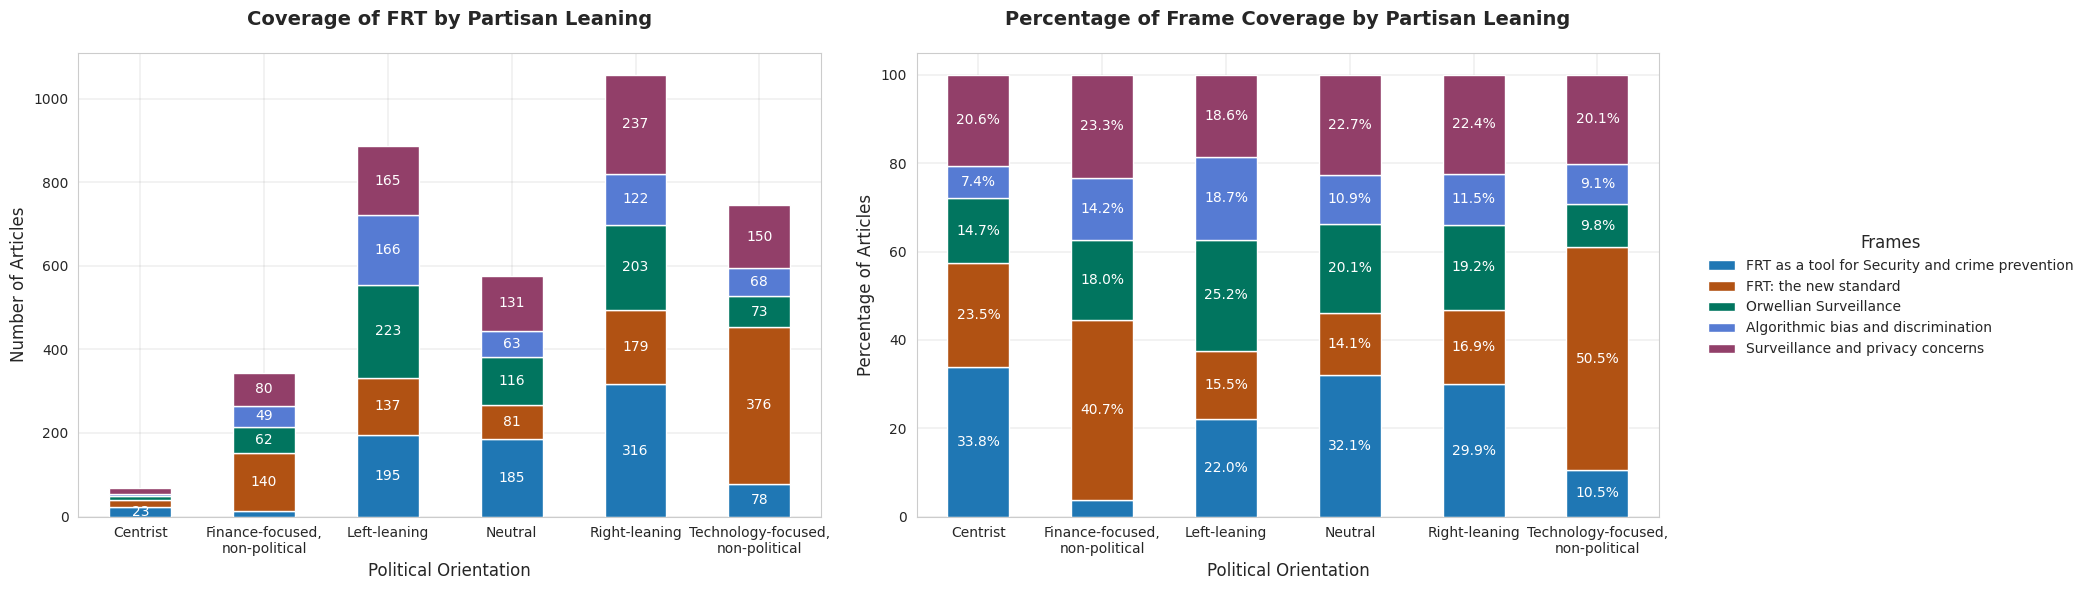

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define colors for the frames
frame_colors = ['#1f77b4', '#b15213', '#01755f', '#567bd3', '#923f69']

# Group data by political orientation and sum the frame occurrences
frames = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

coverage_by_orientation = df_final.groupby('political_orientation')[frames].sum()

# Normalize the data to get percentages (for proportional comparison)
coverage_percentage = coverage_by_orientation.div(coverage_by_orientation.sum(axis=1), axis=0) * 100

# Define new political orientation labels with line breaks
formatted_labels = {
    'Centrist': 'Centrist',
    'Finance-focused, non-political': 'Finance-focused,\nnon-political',
    'Neutral': 'Neutral',
    'Right-leaning': 'Right-leaning',
    'Left-leaning': 'Left-leaning',
    'Technology-focused, non-political': 'Technology-focused,\nnon-political'
}

# Replace index with formatted labels
coverage_by_orientation.index = coverage_by_orientation.index.map(formatted_labels)
coverage_percentage.index = coverage_percentage.index.map(formatted_labels)

# Initialize the subplots
fig, axes = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'width_ratios': [3, 3]}, sharey=False)

# Plot absolute values
coverage_by_orientation.plot(
    kind='bar',
    stacked=True,
    ax=axes[0],
    color=frame_colors,
    edgecolor='white',  # Change edge color to white
    legend=False  # Disable individual legend
)
axes[0].set_title('Coverage of FRT by Partisan Leaning', fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Political Orientation', fontsize=12)
axes[0].set_ylabel('Number of Articles', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)  # Horizontal labels
axes[0].grid(visible=True, color='gray', linestyle='-', linewidth=0.2, alpha=0.7)  # Add grid



# Add values inside the bars for absolute counts
for container in axes[0].containers:
    labels = [f'{int(val)}' if val > 20 else '' for val in container.datavalues]  # Only show if value > 5
    axes[0].bar_label(container, labels=labels, label_type='center', color='white', fontsize=10)


# Plot percentages
coverage_percentage.plot(
    kind='bar',
    stacked=True,
    ax=axes[1],
    color=frame_colors,
    edgecolor='white',  # Change edge color to white
    legend=False  # Disable individual legend
)
axes[1].set_title('Percentage of Frame Coverage by Partisan Leaning', fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Political Orientation', fontsize=12)
axes[1].set_ylabel('Percentage of Articles', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)  # Horizontal labels
axes[1].grid(visible=True, color='gray', linestyle='-', linewidth=0.2, alpha=0.7)  # Add grid

# Add values inside the bars for percentages
for container in axes[1].containers:
    labels = [f'{val:.1f}%' if val > 5 else '' for val in container.datavalues]  # Only show if value > 5%
    axes[1].bar_label(container, labels=labels, label_type='center', color='white', fontsize=10)

# Add a shared legend to the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title='Frames', title_fontsize=12, frameon=False
)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space at the right for the shared legend
plt.show()


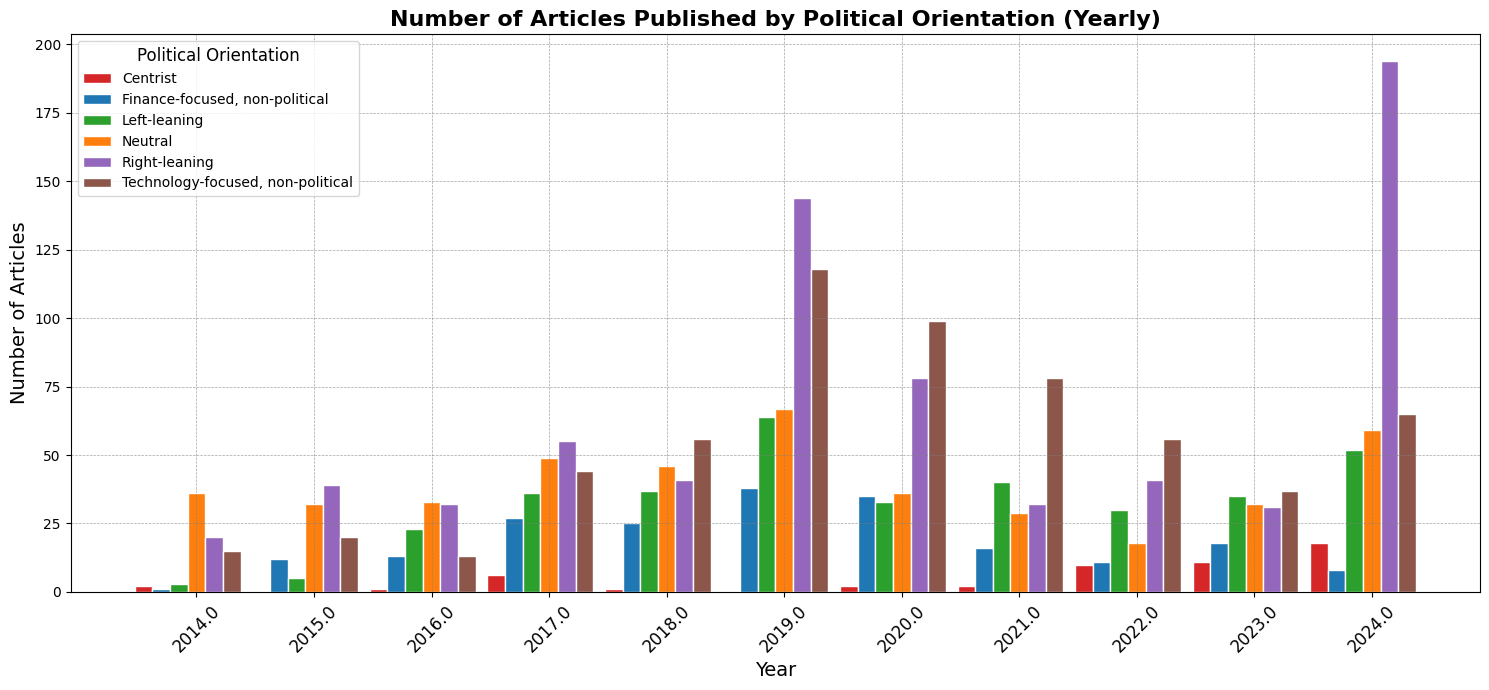

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'date' column is datetime and extract year
df_final['year'] = pd.to_datetime(df_final['date'], errors='coerce').dt.year

# Group data by year and political orientation, counting the number of articles
article_counts = (
    df_final.groupby(['year', 'political_orientation'])
    .size()
    .reset_index(name='article_count')
)

# Define unique years and political orientations
years = article_counts['year'].unique()
political_orientations = article_counts['political_orientation'].unique()

# Create x-positions for bars
x_positions = np.arange(len(years))
bar_width = 0.15  # Adjust width of the bars for clear grouping

# Initialize the plot
fig, ax = plt.subplots(figsize=(15, 7))

# Plot bars for each political orientation
colors = ['#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b']  # Custom colors for each group
for i, political_orientation in enumerate(political_orientations):
    subset = article_counts[article_counts['political_orientation'] == political_orientation]
    subset = subset.set_index('year').reindex(years).fillna(0)  # Ensure all years are included
    y_values = subset['article_count']

    ax.bar(
        x_positions + i * bar_width,
        y_values,
        bar_width,
        label=political_orientation,
        color=colors[i % len(colors)],
        edgecolor='white'
    )

# Add labels and title
ax.set_title('Number of Articles Published by Political Orientation (Yearly)', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Number of Articles', fontsize=14)
ax.set_xticks(x_positions + (len(political_orientations) * bar_width) / 2)
ax.set_xticklabels(years, fontsize=12, rotation=45)
ax.legend(title='Political Orientation', fontsize=10, title_fontsize=12, loc='upper left')

# Add gridlines for readability
ax.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Define the columns for frame predictions
frame_columns = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

# Group by political orientation and sum the frame predictions
frame_counts = df_final.groupby('political_orientation')[frame_columns].sum()

# Calculate the total number of articles for each political orientation
total_articles_by_orientation = frame_counts.sum(axis=1)

# Calculate proportions for each frame relative to the total articles for that political orientation
frame_proportions = frame_counts.div(total_articles_by_orientation, axis=0) * 100  # Convert to percentage

# Combine counts and proportions into one DataFrame for better overview
frame_summary = pd.concat(
    [frame_counts, frame_proportions],
    axis=1,
    keys=['Counts', 'Proportions (%)']
)

# Display the summary table in a clean format
for orientation in frame_summary.index:
    print(f"Political Orientation: {orientation}")
    print(frame_summary.loc[orientation].to_string(header=True))
    print("-" * 50)




Political Orientation: Centrist
Counts           FRT as a tool for Security and crime prevention    23.000000
                 FRT: the new standard                              16.000000
                 Orwellian Surveillance                             10.000000
                 Algorithmic bias and discrimination                 5.000000
                 Surveillance and privacy concerns                  14.000000
Proportions (%)  FRT as a tool for Security and crime prevention    33.823529
                 FRT: the new standard                              23.529412
                 Orwellian Surveillance                             14.705882
                 Algorithmic bias and discrimination                 7.352941
                 Surveillance and privacy concerns                  20.588235
--------------------------------------------------
Political Orientation: Finance-focused, non-political
Counts           FRT as a tool for Security and crime prevention     13.000000
    

## Subquestion 4: How do frames used in the coverage of FRT differ according to the type of media outlet?

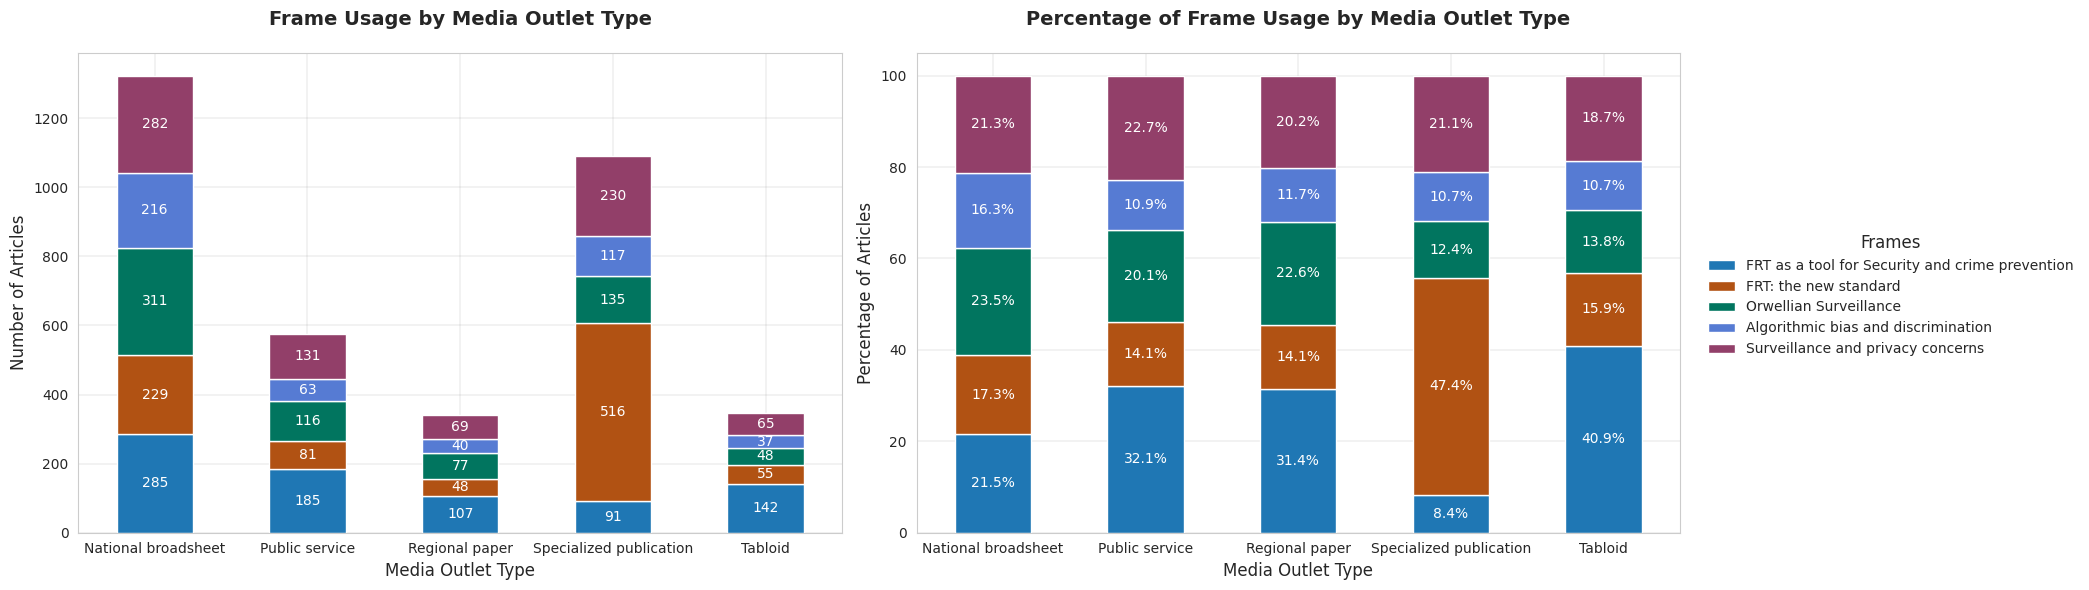

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define colors for the frames
frame_colors = ['#1f77b4', '#b15213', '#01755f', '#567bd3', '#923f69']

# Group data by media outlet type and sum the frame occurrences
frames = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

# Update this to match your column name for media outlet categorization
media_outlet_col = 'categorisation'

coverage_by_media = df_final.groupby(media_outlet_col)[frames].sum()

# Normalize the data to get percentages (for proportional comparison)
coverage_percentage = coverage_by_media.div(coverage_by_media.sum(axis=1), axis=0) * 100

# Initialize the subplots
fig, axes = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'width_ratios': [3, 3]}, sharey=False)

# Plot absolute values
coverage_by_media.plot(
    kind='bar',
    stacked=True,
    ax=axes[0],
    color=frame_colors,
    edgecolor='white',  # Change edge color to white
    legend=False  # Disable individual legend
)
axes[0].set_title('Frame Usage by Media Outlet Type', fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Media Outlet Type', fontsize=12)
axes[0].set_ylabel('Number of Articles', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)  # Horizontal labels
axes[0].grid(visible=True, color='gray', linestyle='-', linewidth=0.2, alpha=0.7)  # Add grid

# Add values inside the bars for absolute counts
for container in axes[0].containers:
    labels = [f'{int(val)}' if val > 20 else '' for val in container.datavalues]  # Only show if value > 20
    axes[0].bar_label(container, labels=labels, label_type='center', color='white', fontsize=10)

# Plot percentages
coverage_percentage.plot(
    kind='bar',
    stacked=True,
    ax=axes[1],
    color=frame_colors,
    edgecolor='white',  # Change edge color to white
    legend=False  # Disable individual legend
)
axes[1].set_title('Percentage of Frame Usage by Media Outlet Type', fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Media Outlet Type', fontsize=12)
axes[1].set_ylabel('Percentage of Articles', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)  # Horizontal labels
axes[1].grid(visible=True, color='gray', linestyle='-', linewidth=0.2, alpha=0.7)  # Add grid

# Add values inside the bars for percentages
for container in axes[1].containers:
    labels = [f'{val:.1f}%' if val > 5 else '' for val in container.datavalues]  # Only show if value > 5%
    axes[1].bar_label(container, labels=labels, label_type='center', color='white', fontsize=10)

# Add a shared legend to the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title='Frames', title_fontsize=12, frameon=False
)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space at the right for the shared legend
plt.show()


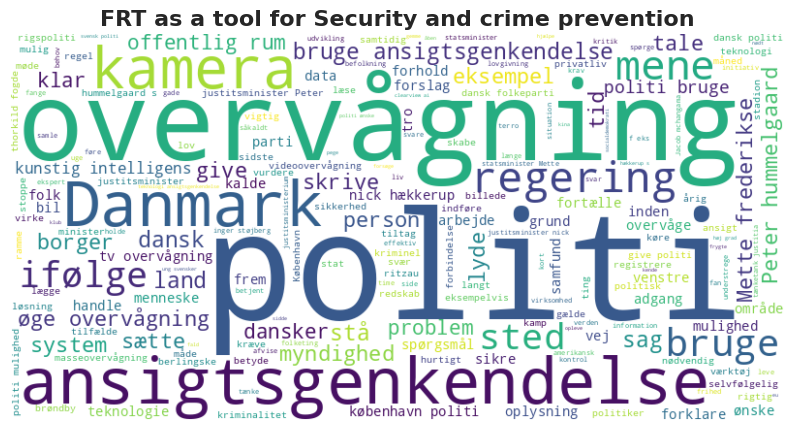

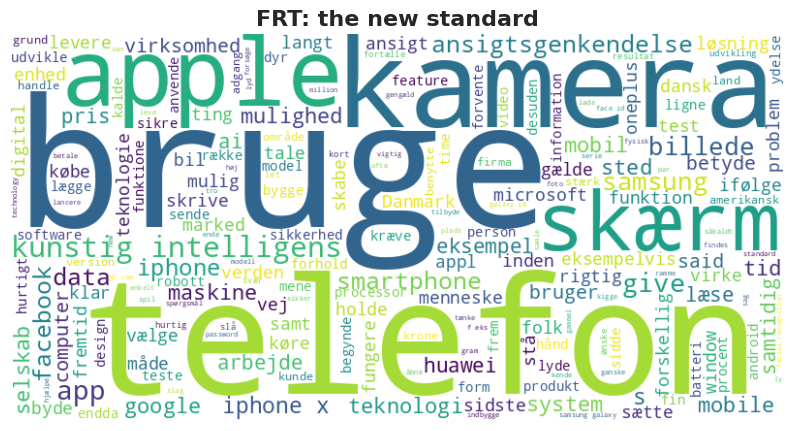

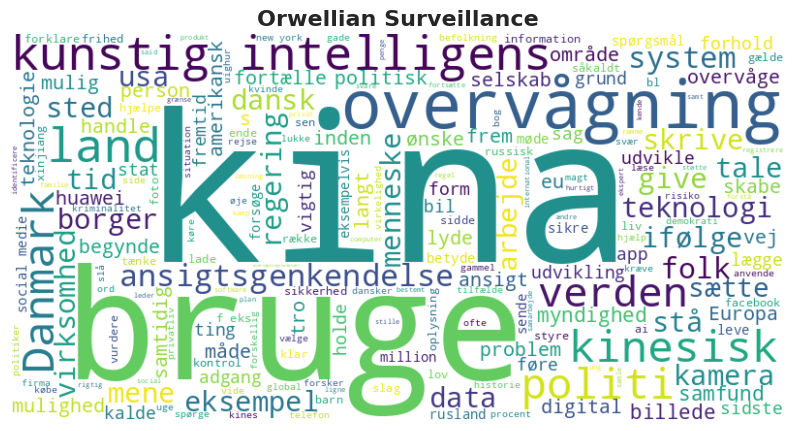

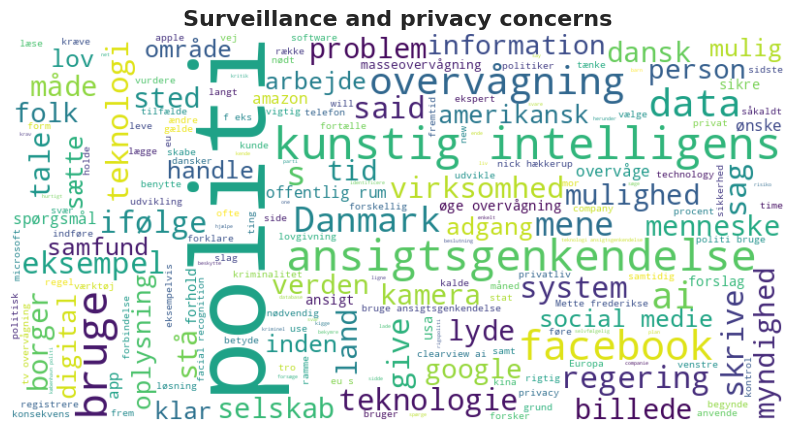

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Load custom Danish stopwords from a file
stopwords_file_path = '/content/gdrive/My Drive/Thesis/stopord.txt'
with open(stopwords_file_path, 'r', encoding='utf-8') as f:
    danish_stopwords = set(line.strip() for line in f)

# Combine Danish and English stopwords
combined_stopwords = STOPWORDS.union(danish_stopwords)

# Generate word clouds for each frame
frames = [
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Orwellian Surveillance',
    'Algorithmic bias and discrimination',
    'Surveillance and privacy concerns'
]

for frame in frames:
    # Filter content by frame
    frame_content = df_final[df_final[frame] == 1]['cleaned_content']
    combined_text = ' '.join(frame_content)

    # Generate the word cloud with combined stopwords
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        stopwords=combined_stopwords  # Use combined stopwords
    ).generate(combined_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(frame.replace('_prediction', ''), fontsize=16, fontweight='bold')
    plt.show()


In [ ]:
df_final

In [ ]:
# Replace `df_combined` with the name of your DataFrame and update `frame_columns` with your column names
frame_columns = [
    'Surveillance and privacy concerns',
    'Orwellian Surveillance',
    'FRT as a tool for Security and crime prevention',
    'FRT: the new standard',
    'Algorithmic bias and discrimination'
]

# Check how many rows have 0 in all the frame columns
rows_with_all_zeros = df_combined[frame_columns].sum(axis=1) == 0

# Count the rows
number_of_rows_with_all_zeros = rows_with_all_zeros.sum()
print(f"Number of rows with 0 in all frame columns: {number_of_rows_with_all_zeros}")


In [ ]:
import pandas as pd

# Assuming your dataframe is named df_combined and the date column is 'date'
df_combined = df_final

# Ensure the 'date' column is in datetime format
df_combined['date'] = pd.to_datetime(df_combined['date'], errors='coerce')

# Extract year and month for grouping
df_combined['year_month'] = df_combined['date'].dt.to_period('M')

# Count the number of articles per month
articles_per_month = df_combined.groupby('year_month').size()

# Compute the mean number of articles per month
mean_articles_per_month = articles_per_month.mean()

print(f"Mean number of articles per month: {mean_articles_per_month}")


Mean number of articles per month: 18.153846153846153


In [ ]:
# prompt: for each year, output the mean and median number pof obsrvation per month

# Assuming your dataframe is named df_combined and the date column is 'date'
df_combined = df_final

# Ensure the 'date' column is in datetime format
df_combined['date'] = pd.to_datetime(df_combined['date'], errors='coerce')

# Extract year and month
df_combined['year'] = df_combined['date'].dt.year
df_combined['month'] = df_combined['date'].dt.month

# Group data by year and month, then count observations
observations_per_month = df_combined.groupby(['year', 'month']).size().reset_index(name='counts')

# Calculate mean and median observations per month for each year
result = observations_per_month.groupby('year').agg(
    mean_observations=('counts', 'mean'),
    median_observations=('counts', 'median')
)

result

mean_observations  median_observations
year                                          
2014.0           6.416667                  5.0
2015.0           9.000000                 10.5
2016.0           9.583333                 10.0
2017.0          18.083333                 16.5
2018.0          17.166667                 18.5
2019.0          35.916667                 23.5
2020.0          23.583333                 19.5
2021.0          16.416667                 17.0
2022.0          13.833333                 13.5
2023.0          13.666667                 11.0
2024.0          39.600000                 19.5

In [ ]:
# Count the number of articles with each dominant frame
dominant_frame_counts = df_final[frames].idxmax(axis=1).value_counts()
dominant_frame_counts.index = dominant_frame_counts.index.str.replace('_prediction', '')

# Plot the data
plt.figure(figsize=(10, 6))
dominant_frame_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Dominant Frame', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.title('Dominance of Frames per Article', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import re

# List of finalized search terms
search_terms = [
    'ansigtsgenkendelse', 'facial recognition', 'face recognition', 'ansigtsaftryk',
    'ansigtsscan', 'masseovervågning ansigt', 'ansigtskamera',
    'overvågningssamfund ansigt', 'sikkerhedspakke overvågning', 'tryghedsskabende kamera'
]

# Function to generate regex patterns for variations of search terms
def generate_regex(term):
    words = term.split()
    if len(words) > 1:
        # Create patterns for multi-word terms
        patterns = [re.escape(word) + r'\w*' for word in words]
        return r'\s+'.join(patterns)
    else:
        # Create patterns for single-word terms
        return re.escape(term) + r'\w*'

# Generate regex pattern for all search terms
regex_pattern = '|'.join([generate_regex(term) for term in search_terms])

# Filter rows in `df_combined` where `merged_content` matches the regex pattern
df_filtered = df_combined[df_combined['merged_content'].str.contains(regex_pattern, flags=re.IGNORECASE, regex=True)]

# Save the filtered DataFrame to a new variable
print(f"Total rows matching search terms: {len(df_filtered)}")

# Optional: Save to a CSV file if needed
# df_filtered.to_csv('filtered_content.csv', index=False)
